In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from tqdm.notebook import tqdm 

import tqdm as notebook_tqdm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Basic Concepts

## White Noise

**Definition**: a time series is characterized as **white noise** when it 
consists of a sequence of uncorrelated random variables, commonly modeled as 
Gaussian (normal) random variables:

$$
x_t = \epsilon_t \\
\epsilon_t \sim N(0, \sigma)
$$

*Observations*:

* **Mean**: The series has a mean of **zero**.
* **Constant Variance**: The variance of the series remains constant and finite 
over time.
* **No Autocorrelation**: There is no predictable pattern or trend in the series.
Each value is statistically independent of other values, implying no correlation 
between past, present, and future values in the series.



## Random Walk

**Definition**: A time series is characterized as following a **random walk** if, 
and only if, the difference between its consecutive values (i.e., the variation 
at each time step) constitutes *white noise*. 

$$
x_t - x_{t-1} = \epsilon_t \\
\epsilon_t \sim N(0, \sigma)
$$

*Observation*: This implies that the changes in the series from one period to the 
next are entirely random and unpredictable, with no discernible pattern or trend, 
meaning that *each change* is **independent** of *past changes*.

# Basic Structural Time Series Model

**Definition** - the **Basic Structural Model** is a framework in time series 
analysis that decomposes a time series into three distinct components: **trend**, 
**cycle**, and **noise**.

$$
y_t = \mu_t + \gamma_t + \epsilon_t
$$

* $\mu_t$: **trend** represents the long-term progression of the series.
* $\gamma_t$: **cycle** accounts for regular but not necessarily seasonal 
fluctuations in the time series.
* $\epsilon_t \sim N(0, \sigma_{\epsilon})$: This is the **random error**, the 
**noise** or the **irregular component** of the series.

## Trends
### Stochastic Trend

The **1-step changes in the trend** are modeled as **random walk** plus 
**white noise**:

$$
\mu_t - \mu_{t-1} = \beta_t + \xi_t \\
\beta_t - \beta_{t-1} = \eta_t
$$

Where:

$$
\xi_t \sim N(0, \sigma_{\mu}) \\
\eta_t \sim N(0, \sigma_{\beta})
$$

Alternatively:

$$
\mu_t \sim N(\mu_{t-1} + \beta_t, \sigma_{\mu}) \\
\beta_t \sim N(\beta_{t-1}, \sigma_{\beta})
$$

*Observation*
Here it is usual to distinguish between:
* **(Local) Level**, $\mu_t$: The baseline value of the series, representing its 
**long-term** average or trend.
* **(Local) Trend**, $\beta_t$: A component that captures the gradual, long-term 
movement in the series. Unlike the level, which is more static, the trend is 
dynamic and can change over time, representing either an upward or downward 
direction in the data.


### Local Level Trend

If $\beta_0 = 0$ and $\sigma_{\beta} = 0$, the stochastic trend is called
*Local Level Trend*.

The **trend** is a **random walk** (equivalent to: "the **1-step changes** in the
trend are modeled as **white noise**"): 

$$
\mu_t - \mu_{t-1} = \xi_t
$$

With:

$$
\xi_t \sim N(0, \sigma_{\mu})
$$

Alternatively:

$$
\mu_t \sim N(\mu_{t-1}, \sigma_{\mu})
$$


## Cycles

# Simulation

In [3]:
import numpy as np
import pandas as pd

def stochastic_trend(
        rng, 
        N = 100, 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 100
        ):
    """Simulate a stochastic trend

    Args:
        rng (_type_): _description_
        N (int, optional): _description_. Defaults to 100.
        sigma_local_trend (int, optional): _description_. Defaults to 1.
        sigma_local_level (int, optional): _description_. Defaults to 1.
        local_level_0 (int, optional): _description_. Defaults to 100.
        local_trend_0 (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    # local trend is a random walk
    diff_local_trend = rng.normal(0, sigma_local_trend, N)
    local_trend      = np.cumsum(diff_local_trend) + local_trend_0

    # local level is the local trend plus noise
    diff_local_level = rng.normal(local_trend, sigma_local_level, N)
    local_level      = np.cumsum(diff_local_level) + local_level_0

    # dataframe with t = 1:N, local_trend, local_level
    df = pd.DataFrame(
        {
            "t": np.arange(1, N + 1),
            "local_trend": local_trend,
            "local_level": local_level,
        }
    )
    return df

def plot_stochastic_trend(df):
    """plot local_trend and local_level vs t, each with a different y-axis

    Args:
        df (_type_): _description_
    """
    # plot local_trend and local_level vs t, each with a different y-axis
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    df.plot(x="t", y=["local_trend"], ax=ax1, alpha=0.5)
    df.plot(x="t", y=["local_level"], ax=ax2, alpha=0.5, color="C1")

    # Add y-axis labels
    ax1.set_ylabel("local_trend")
    ax2.set_ylabel("local_level")

    # Add a legend
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    # Add a title
    plt.title("Local Trend and Local Level")

    # Add horizontal dotted line at local_trend = 0
    ax1.axhline(0, linestyle="--", color="black", alpha=0.5)

    fig.tight_layout()
    plt.show()

def local_level_trend(
        rng, 
        N = 100, 
        sigma = 1, 
        level_0 = 100
        ):
    """simulate a local level trend

    Args:
        rng (_type_): _description_
        N (int, optional): _description_. Defaults to 100.
        sigma_local_trend (int, optional): _description_. Defaults to 1.
        sigma_local_level (int, optional): _description_. Defaults to 1.
        local_level_0 (int, optional): _description_. Defaults to 100.
        local_trend_0 (int, optional): _description_. Defaults to 1.
    """

    df = stochastic_trend(
        rng, 
        N = N, 
        sigma_local_trend = 0, 
        local_trend_0 = 0, 
        sigma_local_level = sigma, 
        local_level_0 = level_0
    )

    return df

def deterministic_trend(
        rng,
        N = 100,
        slope = 1,
        intercept = 100
):
    """simulate a deterministic trend
    """

    df = stochastic_trend(
        rng, 
        N = N, 
        sigma_local_trend = 0, 
        local_trend_0 = slope, 
        sigma_local_level = 0, 
        local_level_0 = intercept
    )

    return df



In [4]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

## Stochastic Trend

C:\Users\mcondedesimon\AppData\Local\Temp\ipykernel_21436\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


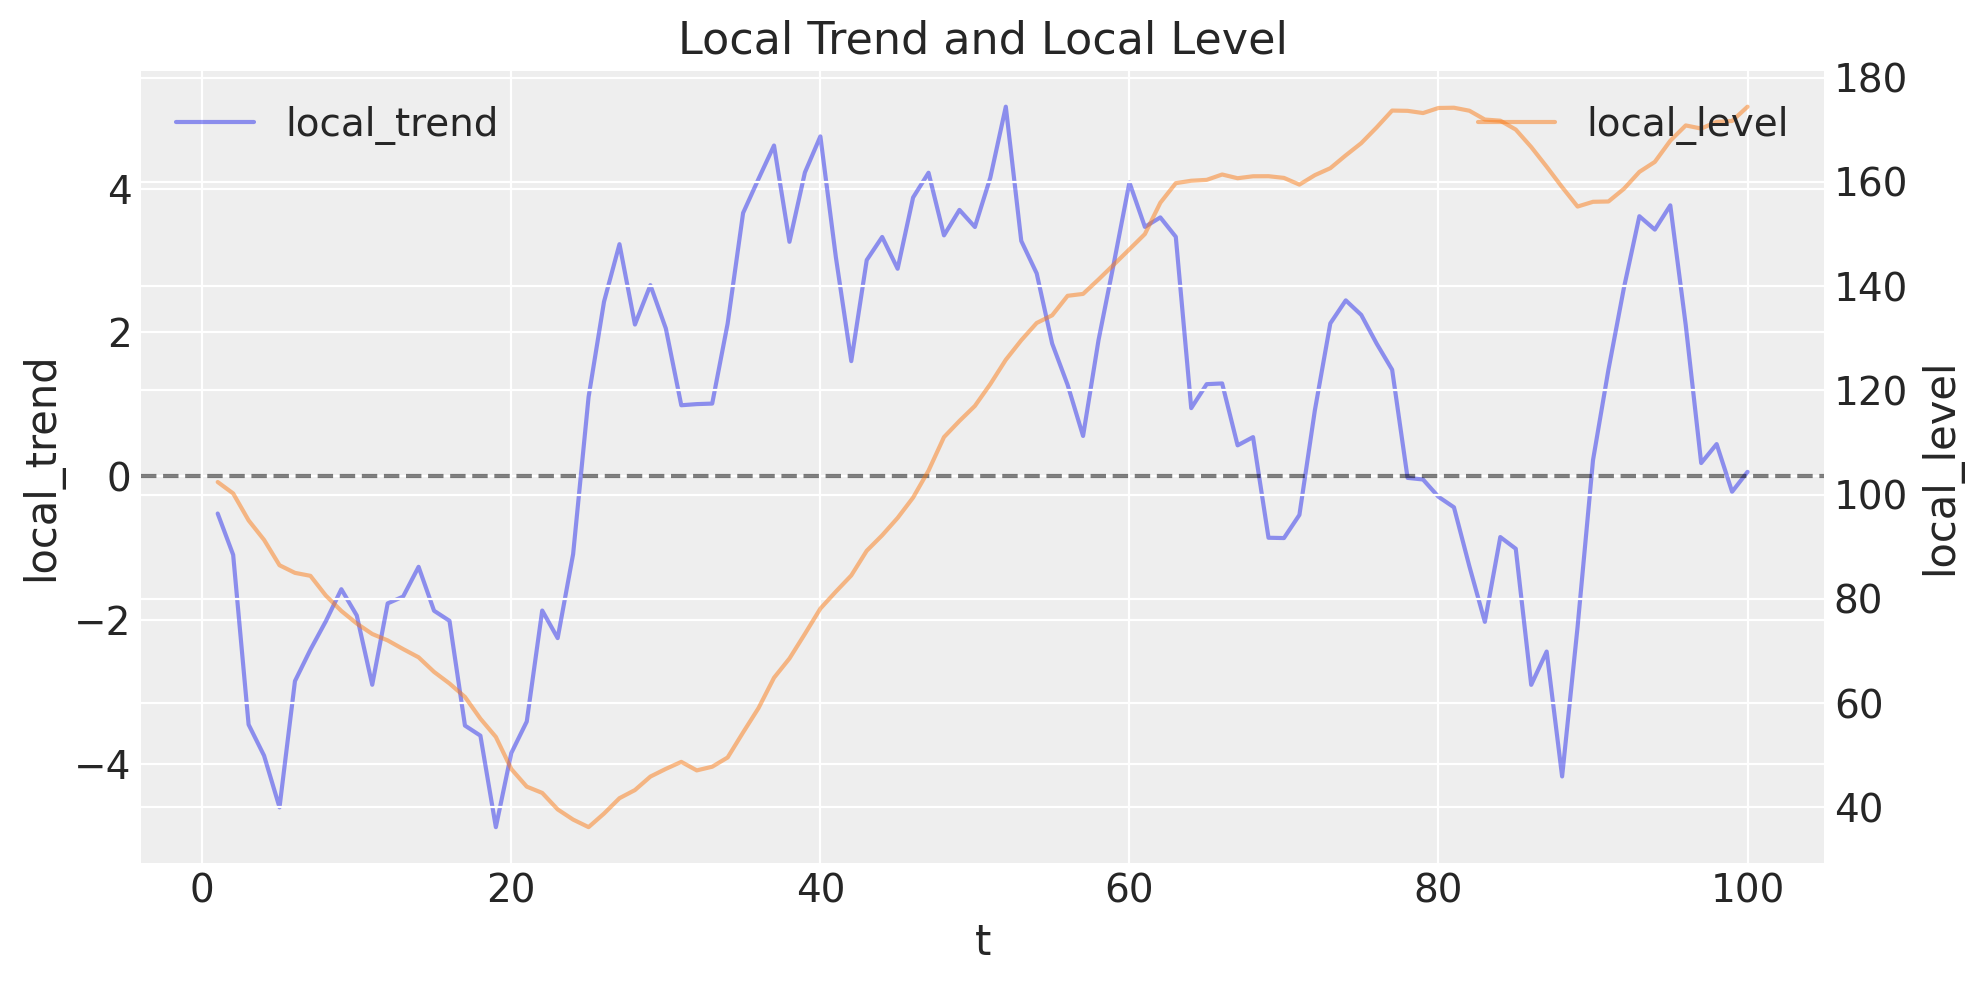

In [5]:
df_stoch_trend = stochastic_trend(
    rng, 
    N = 100, 
    sigma_local_trend = 1, 
    local_trend_0 = 1, 
    sigma_local_level = 1, 
    local_level_0 = 100
    )

plot_stochastic_trend(df_stoch_trend)

C:\Users\mcondedesimon\AppData\Local\Temp\ipykernel_21436\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


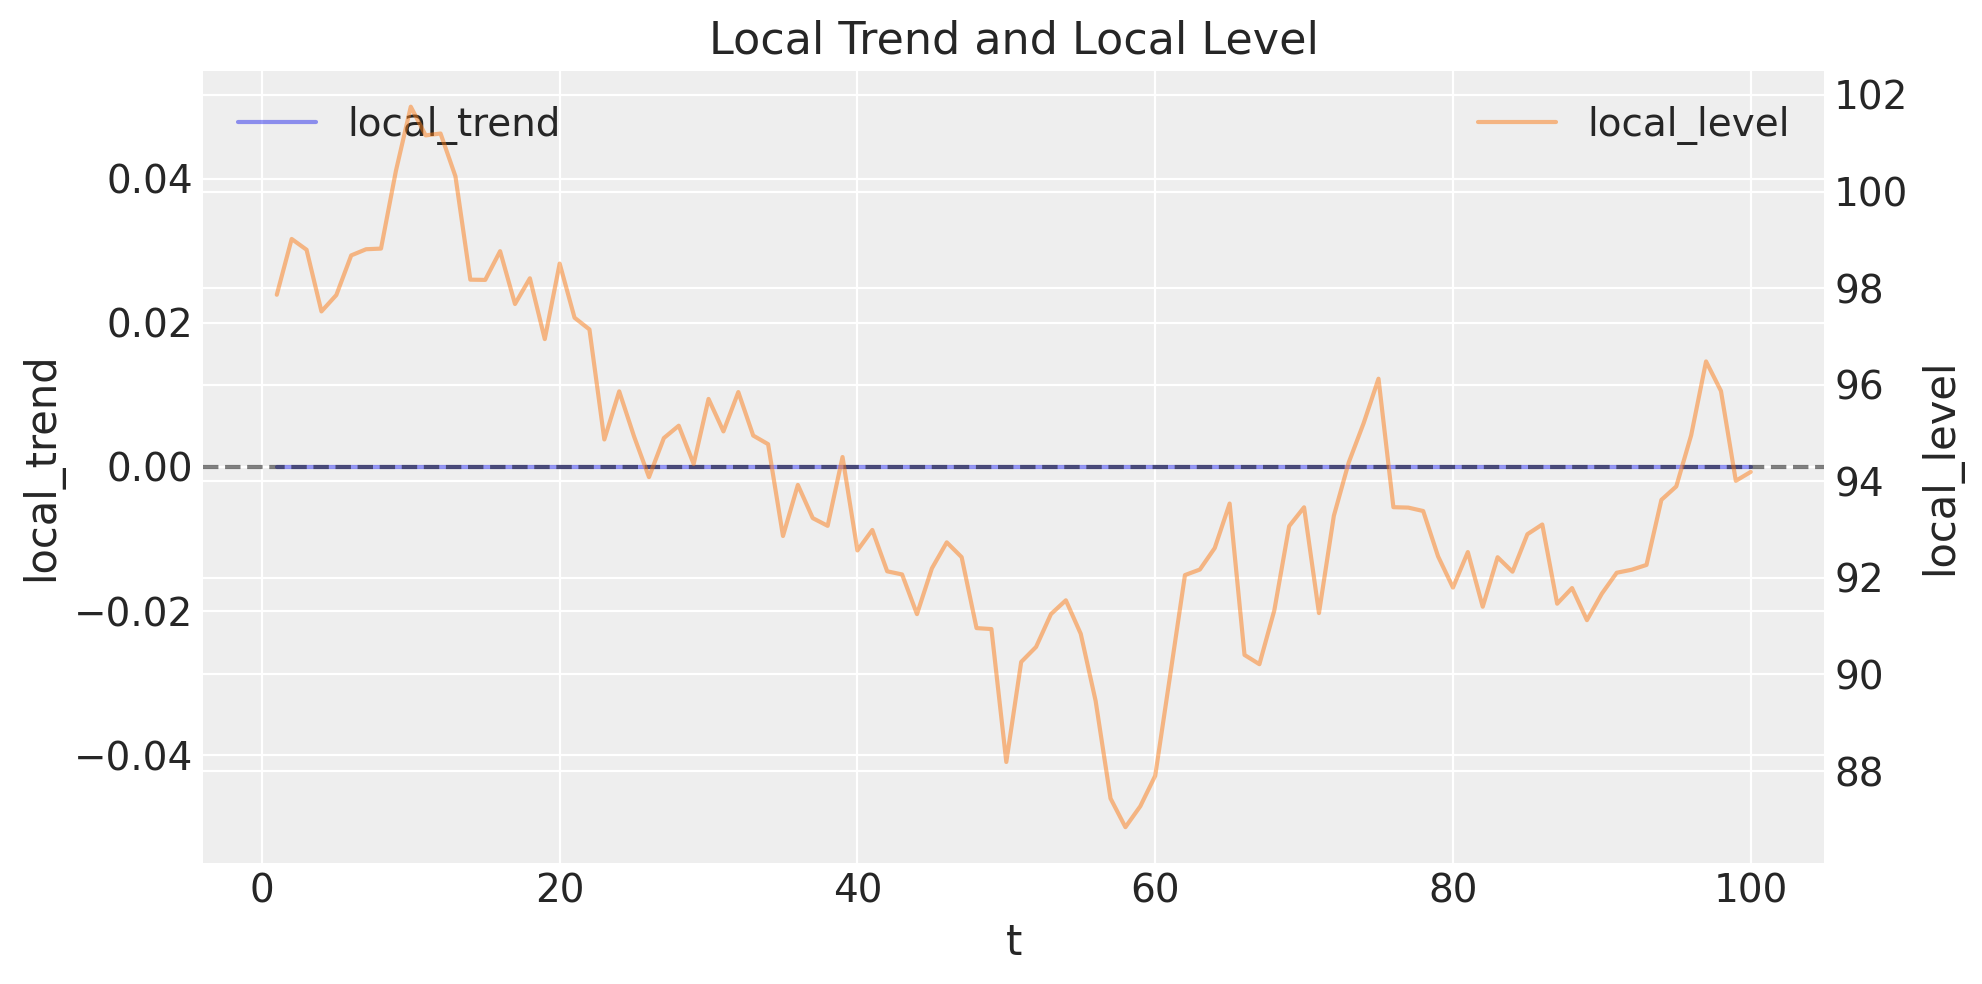

In [6]:
df_local_level_trend = local_level_trend(
    rng, 
    N = 100, 
    sigma = 1, 
    level_0 = 100
    )

plot_stochastic_trend(df_local_level_trend)

C:\Users\mcondedesimon\AppData\Local\Temp\ipykernel_21436\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


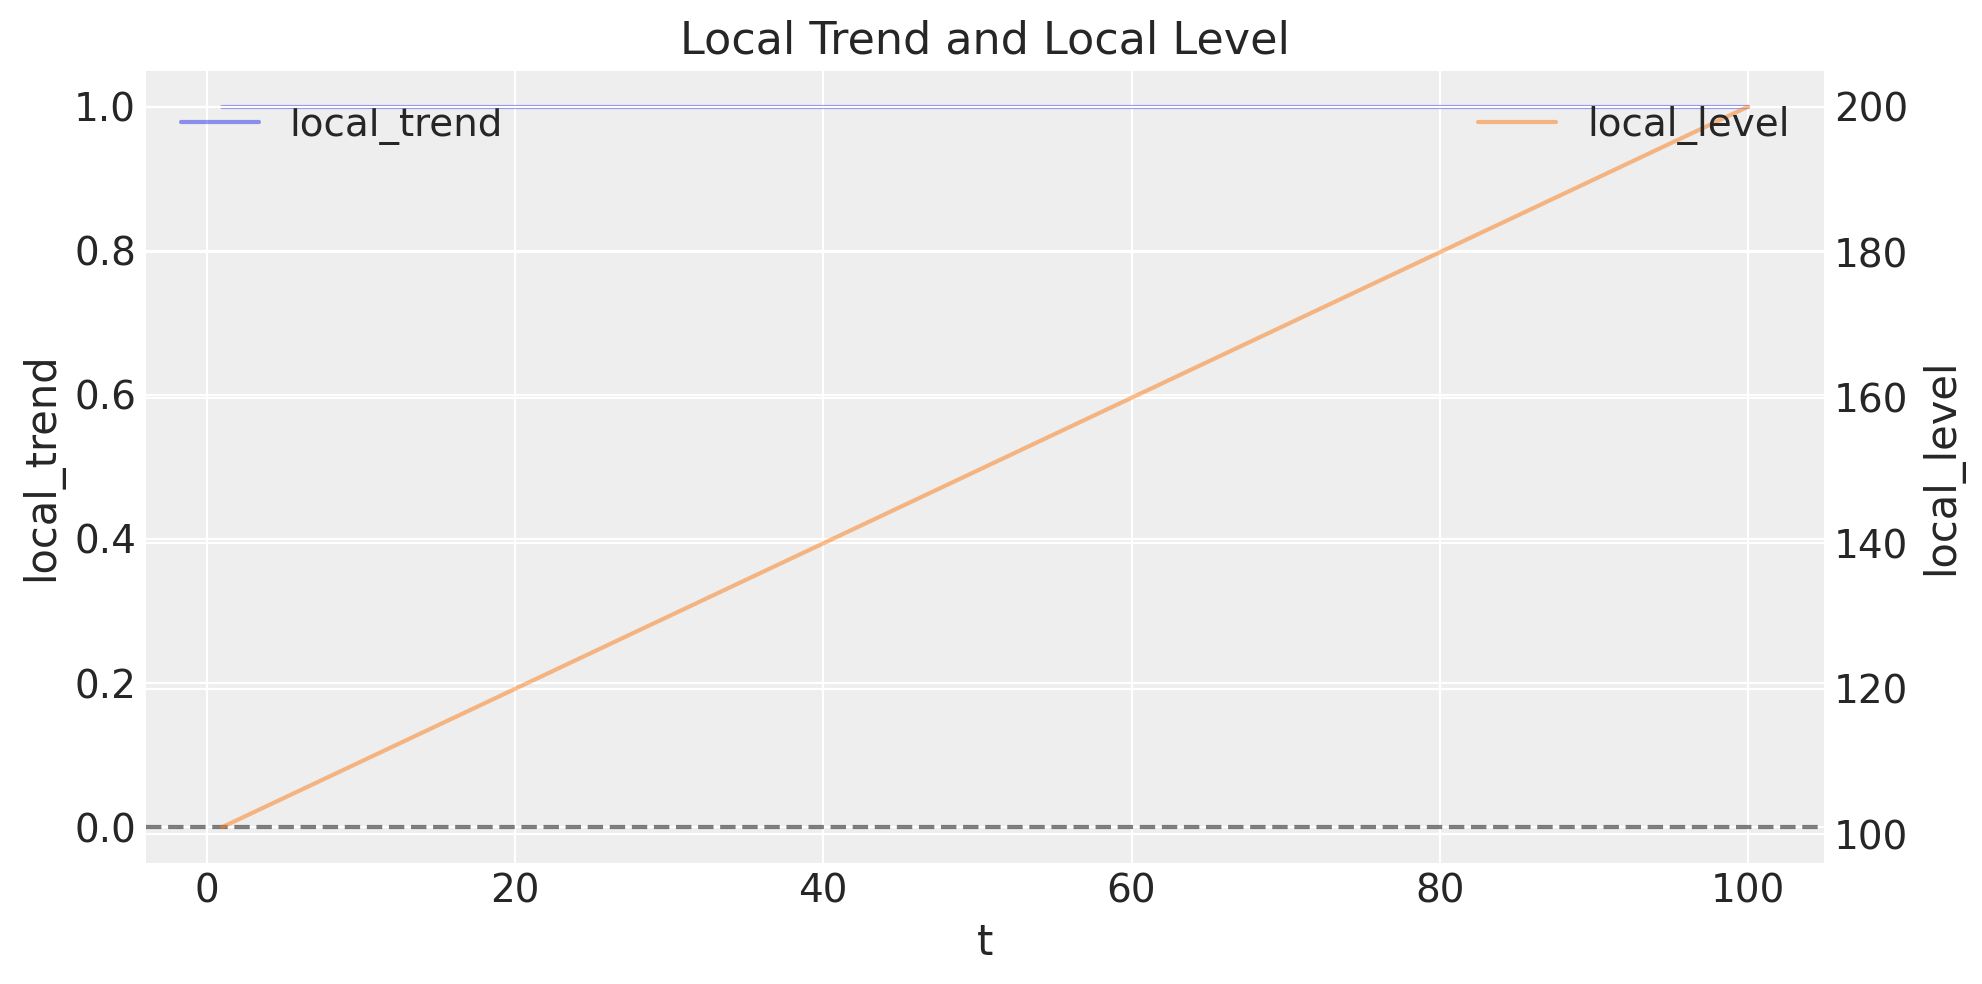

In [7]:
df_deterministic_trend = deterministic_trend(
    rng, 
    N = 100, 
    slope = 1, 
    intercept = 100
    )

plot_stochastic_trend(df_deterministic_trend)

### Cycles

In [8]:
# Dataframe con columna 'fecha' desde 2021-01-01 hasta 2023-11-30, con frecuencia semanal
df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

# Agregamos columna 't' con el número de semana
df["t"] = df.index + 1

# Agregamos el dia de la semana como string
df["dia_semana"] = df["fecha"].dt.day_name()

# Agregamos el dia de la semana como numero
df["dia_semana_num"] = df["fecha"].dt.dayofweek + 1

df.head()

fecha  t dia_semana  dia_semana_num
0 2021-01-01  1     Friday               5
1 2021-01-02  2   Saturday               6
2 2021-01-03  3     Sunday               7
3 2021-01-04  4     Monday               1
4 2021-01-05  5    Tuesday               2

In [9]:
def make_fourier_features(df, date_var_name, n_order=10, period=365.25):
    """
    Generate Fourier features based on a given date variable in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the date variable.
        date_var_name (str): The name of the date variable column in the DataFrame.
        n_order (int, optional): The number of Fourier orders to generate. Defaults to 10.
        period (float, optional): The period of the Fourier series. Defaults to 365.25.

    Returns:
        pandas.DataFrame: A DataFrame containing the Fourier features.
    """
    # Calculate the periods based on the date variable
    periods = (df[date_var_name] - pd.Timestamp("1900-01-01")).dt.days / period

    # Generate the Fourier features using sine and cosine functions
    fourier_features = pd.DataFrame(
        {
            f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
            for order in range(1, n_order + 1)
            for func in ("sin", "cos")
        }
    )

    return fourier_features

<Axes: xlabel='fecha'>

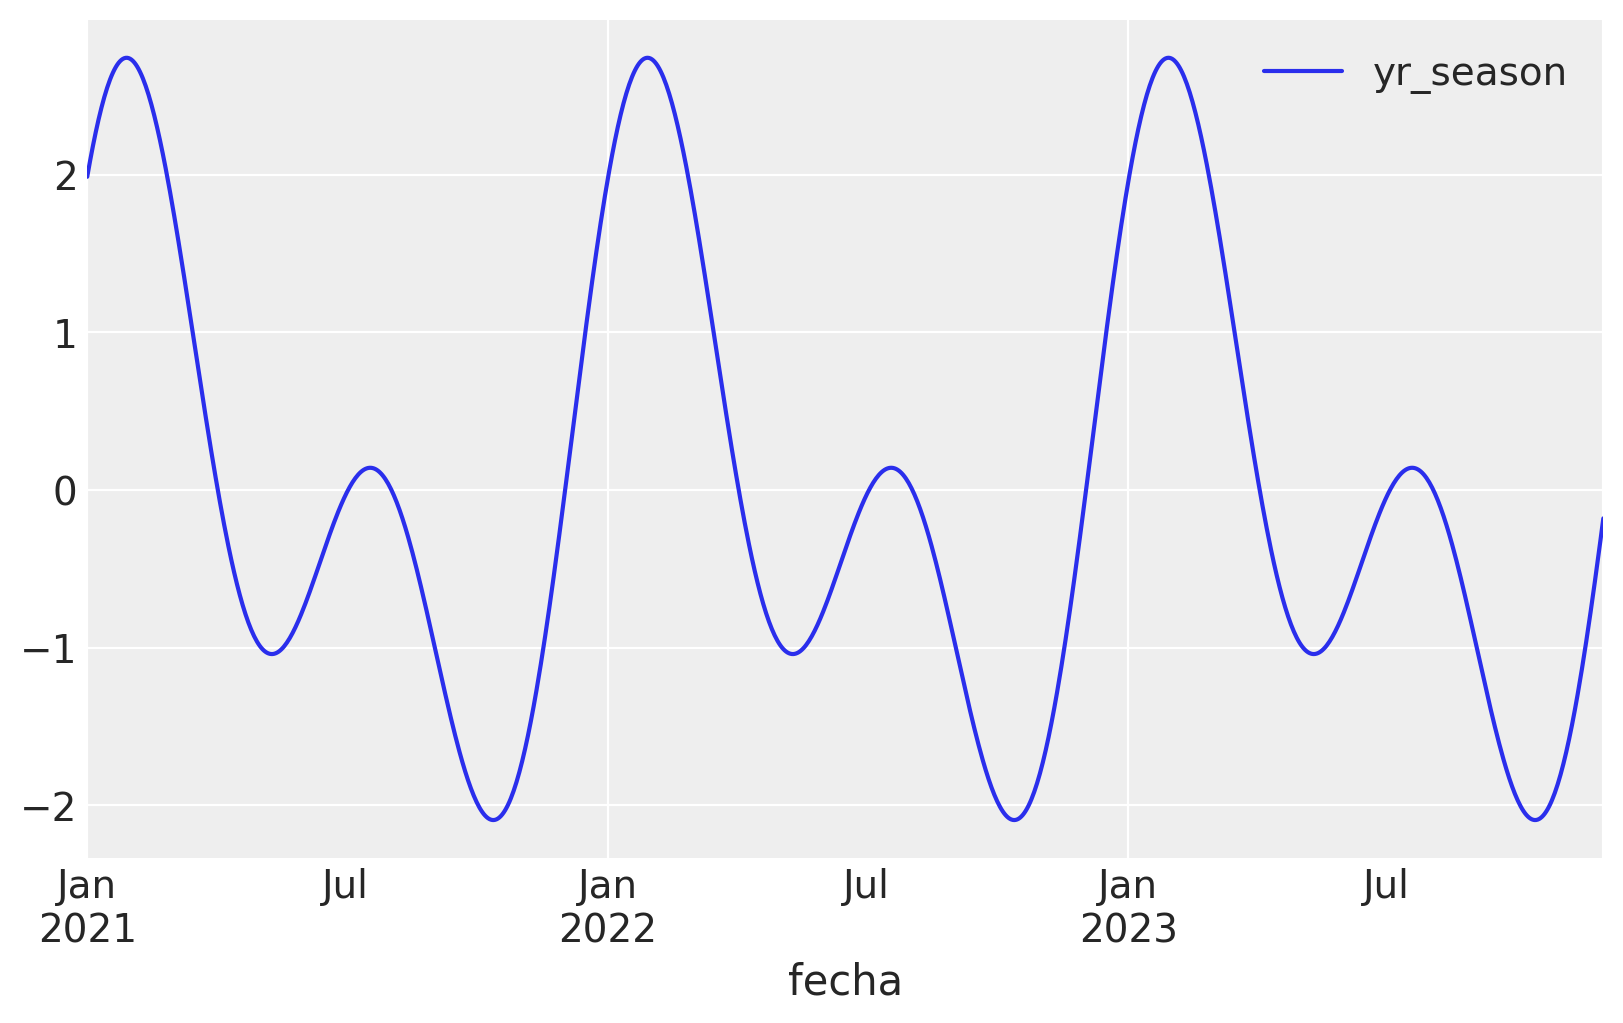

In [10]:
fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)

# genera un numpy array con shape (1, df.shape[0]) yllénalo con valores aleatorios
fourier_coefs = np.array(rng.uniform(0, 1, fourier_features.shape[1]))
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

# Multiplica matricialmente las fourier_features por four_coefs
df['yr_season'] = np.dot(fourier_features, fourier_coefs)

df.plot(x="fecha", y=["yr_season"])


# Modeling

## Trend

In [11]:
df = df_stoch_trend.assign(y = lambda x: x.local_level + rng.normal(0, 1, 100))

In [12]:
df.head()

t  local_trend  local_level           y
0  1    -0.521628   102.402626  103.090206
1  2    -1.095988   100.213918  100.176089
2  3    -3.458094    95.041352   95.357463
3  4    -3.890317    91.306045   90.350359
4  5    -4.609461    86.437916   86.573733

<Axes: xlabel='t'>

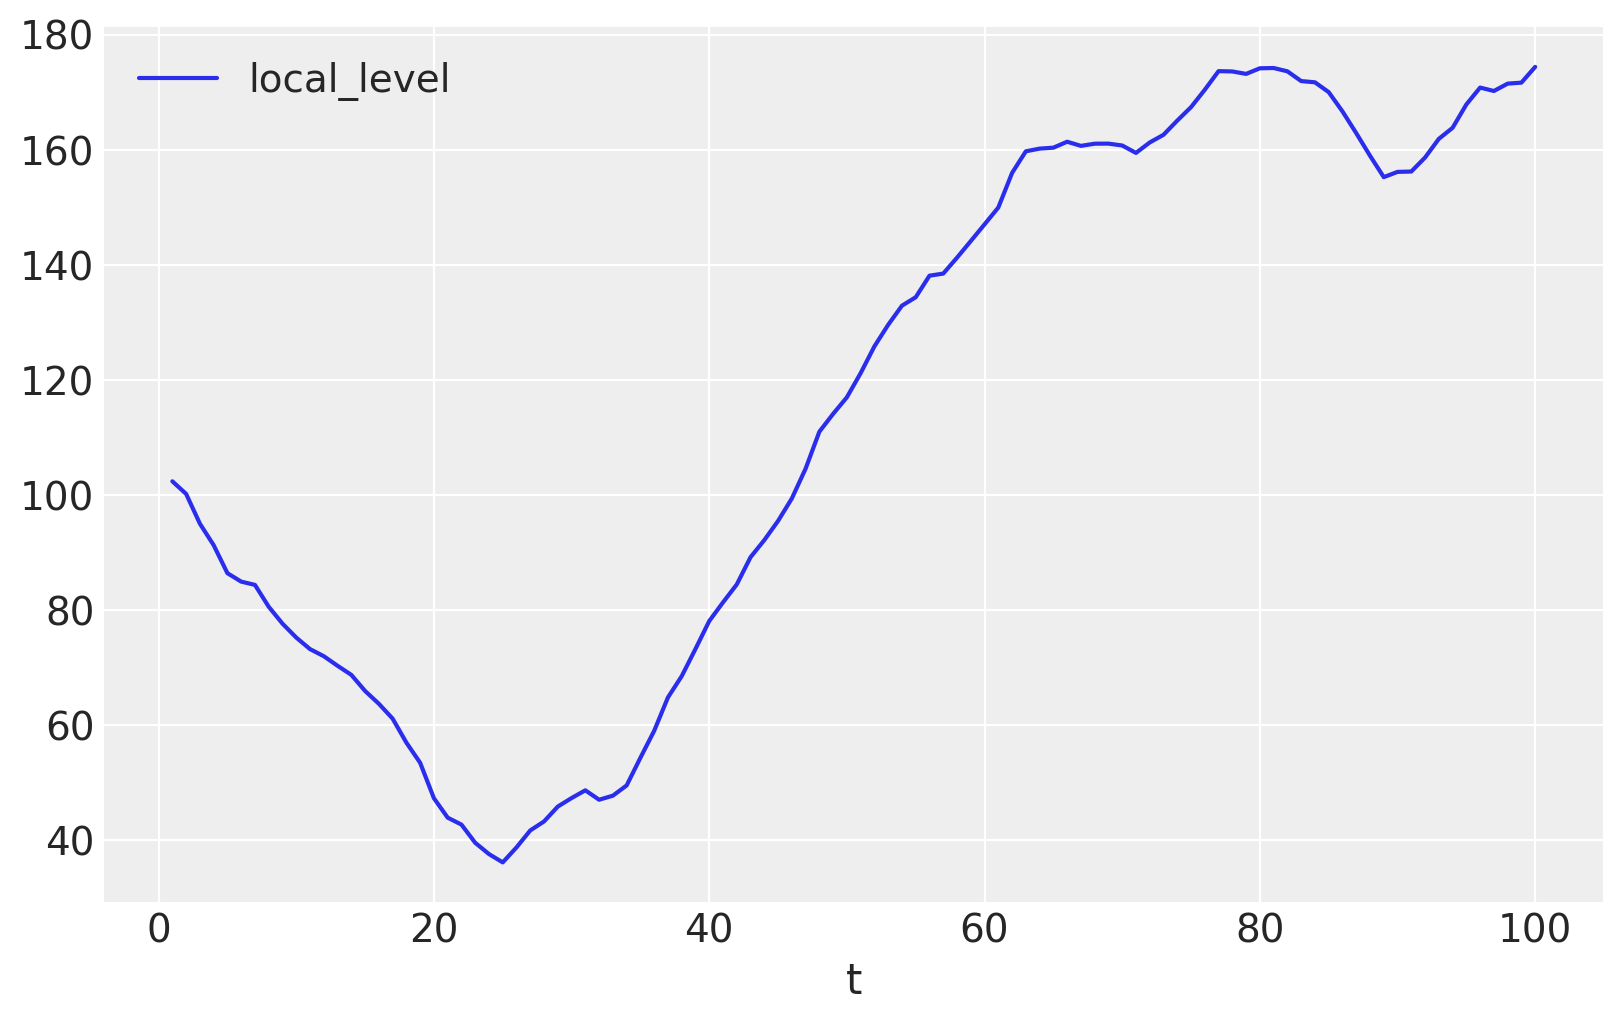

In [13]:
df.plot(x="t", y=["local_level"])

### 0 - Scale the data

In [14]:
t = df["t"].to_numpy()

# Max-min scaling
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

In [15]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

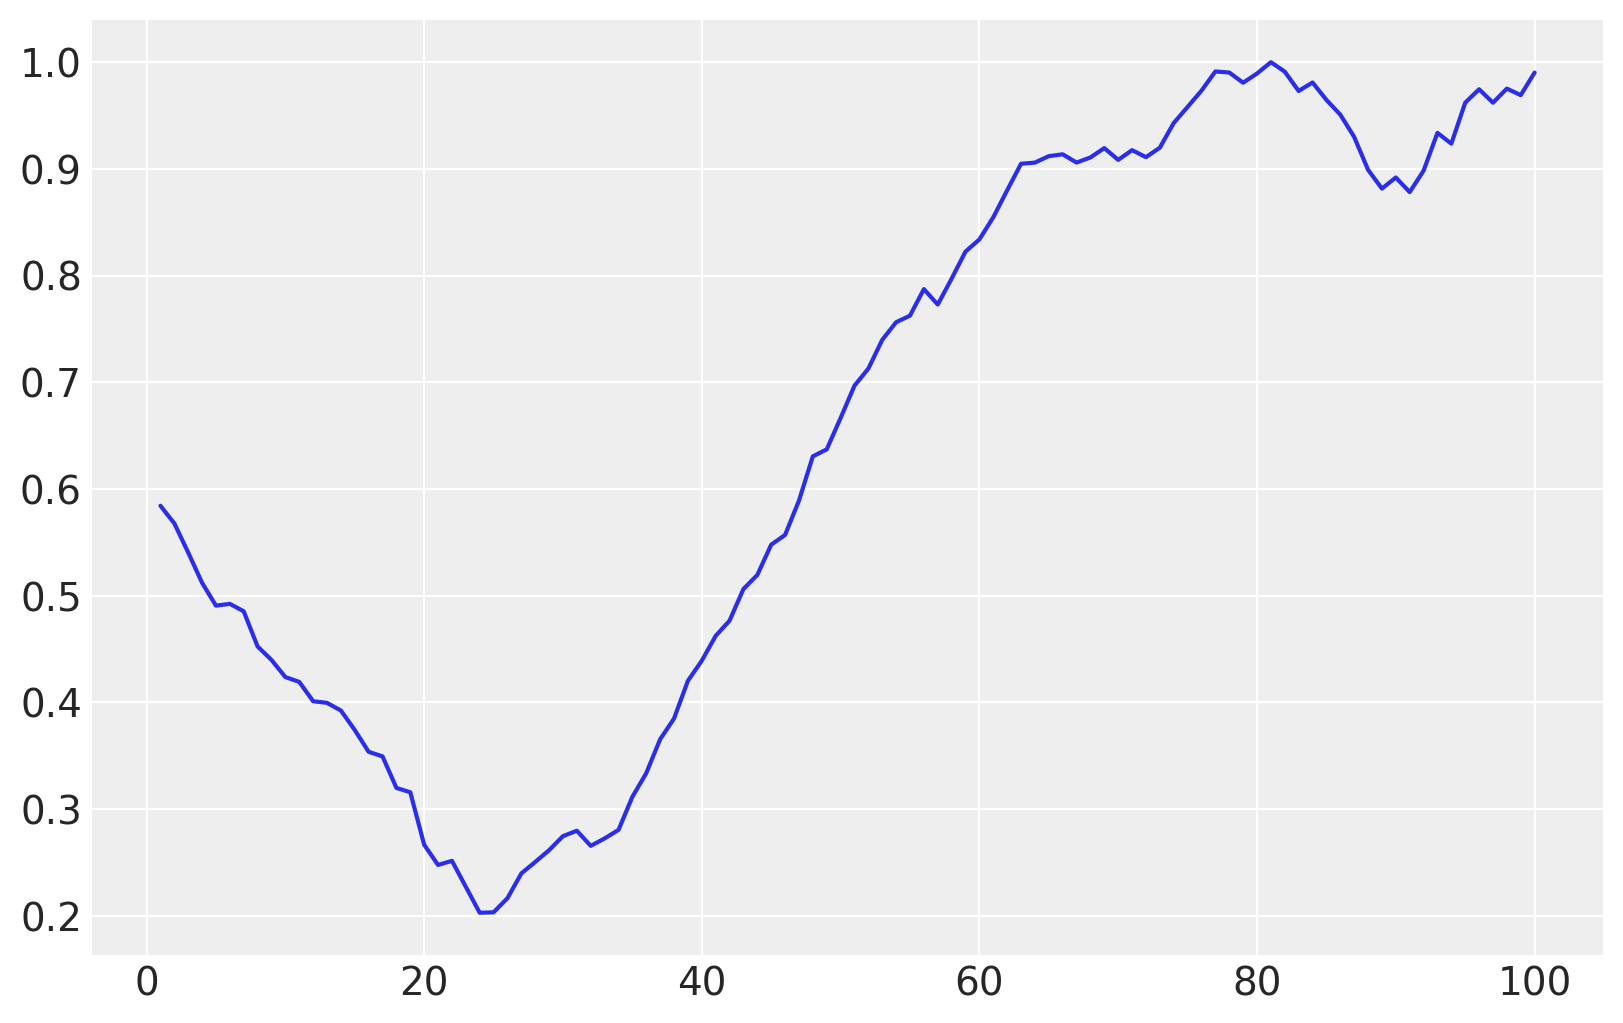

In [24]:
plt.plot(df['t'], y)

### 1 - Model

In [76]:
np.square(y_max)

31124.166200277356

In [77]:
coords = {'n_obs': df.index}

with pm.Model(coords=coords, check_bounds=False) as stochastic_trend_model:

    sigma_local_trend = pm.Exponential("sigma_local_trend", lam=y_max * 1)  # 20
    sigma_local_level = pm.Exponential("sigma_local_level", lam=y_max * 1)  # 20
    sigma             = pm.Exponential("sigma", lam=y_max * 1)              # .1

    local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=1e-1)
    diff_local_trend = pm.Normal("diff_local_trend", mu=0, sigma=sigma_local_trend, dims="n_obs")
    local_trend      = pm.Deterministic("local_trend", diff_local_trend.cumsum() + local_trend_0, dims="n_obs")
    
    local_level_0    = pm.Normal("local_level_0", mu=0, sigma=.5)
    diff_local_level = pm.Normal("diff_local_level", mu=local_trend, sigma=sigma_local_level, dims="n_obs")
    local_level      = pm.Deterministic("local_level", diff_local_level.cumsum() + local_level_0, dims="n_obs")

    y_obs = pm.Normal("y_obs", mu=local_level, sigma=sigma, dims="n_obs", observed=y)

    stochastic_trend_prior = pm.sample_prior_predictive()

Sampling: [diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y_obs]


In [65]:
stochastic_trend_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

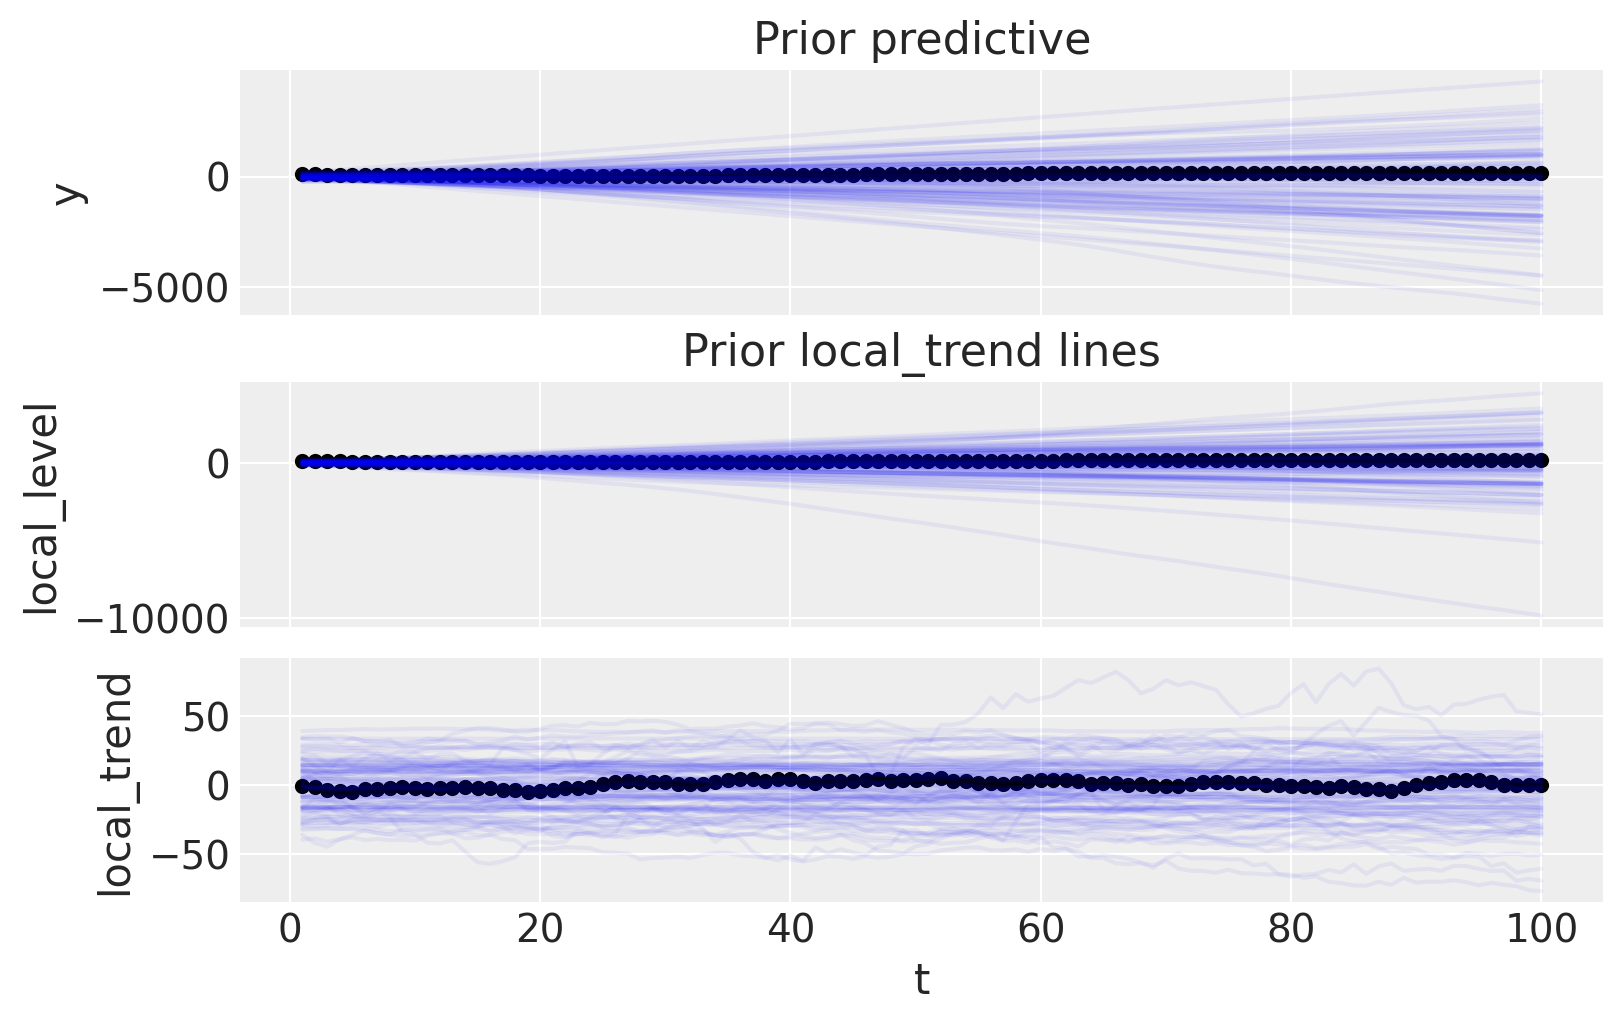

In [78]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior_predictive", num_samples=100)["y_obs"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[1].set_title("Prior local_trend lines");

In [79]:
with stochastic_trend_model:
    # inference data, trace, posterior
    idata = pm.sample(
        return_inferencedata=True, 
        target_accept=0.9,
        draws=12000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    ppc = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:04.597880
Sampling...


Compiling.. :   0%|          | 0/13000 [00:00<?, ?it/s]











Running chain 0:   0%|          | 0/13000 [00:10<?, ?it/s]











Running chain 0:   5%|▌         | 650/13000 [00:17<02:04, 99.45it/s]












Running chain 0:   5%|▌         | 650/13000 [00:29<02:04, 99.45it/s]





Running chain 0:  10%|█         | 1300/13000 [00:34<03:53, 50.02it/s]















Running chain 0:  10%|█         | 1300/13000 [00:49<03:53, 50.02it/s]

Running chain 0:  15%|█▌        | 1950/13000 [00:50<03:59, 46.22it/s]















Running chain 0:  20%|██        | 2600/13000 [01:02<03:35, 48.23it/s]





















Running chain 0:  25%|██▌       | 3250/13000 [01:17<03:27, 46.99it/s]















Running chain 0:  30%|███       | 3900/13000 [01:28<03:03, 49.58it/s]











Running chain 0:  35%|███▌      | 4550/13000 [01:38<02:33, 55.15it/s]



Running chain 0:  40%|████      | 5200/13000 [01:45<02:05, 62.06it/s]









Running chain 0:  55%|█████▌    | 7150/13000 [02:07<01:13,

Sampling time =  0:03:13.996898
Transforming variables...
Transformation time =  0:00:00.986033
Computing Log Likelihood...
Log Likelihood time =  0:00:00.705502


Sampling: [y_obs]


In [92]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [93]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

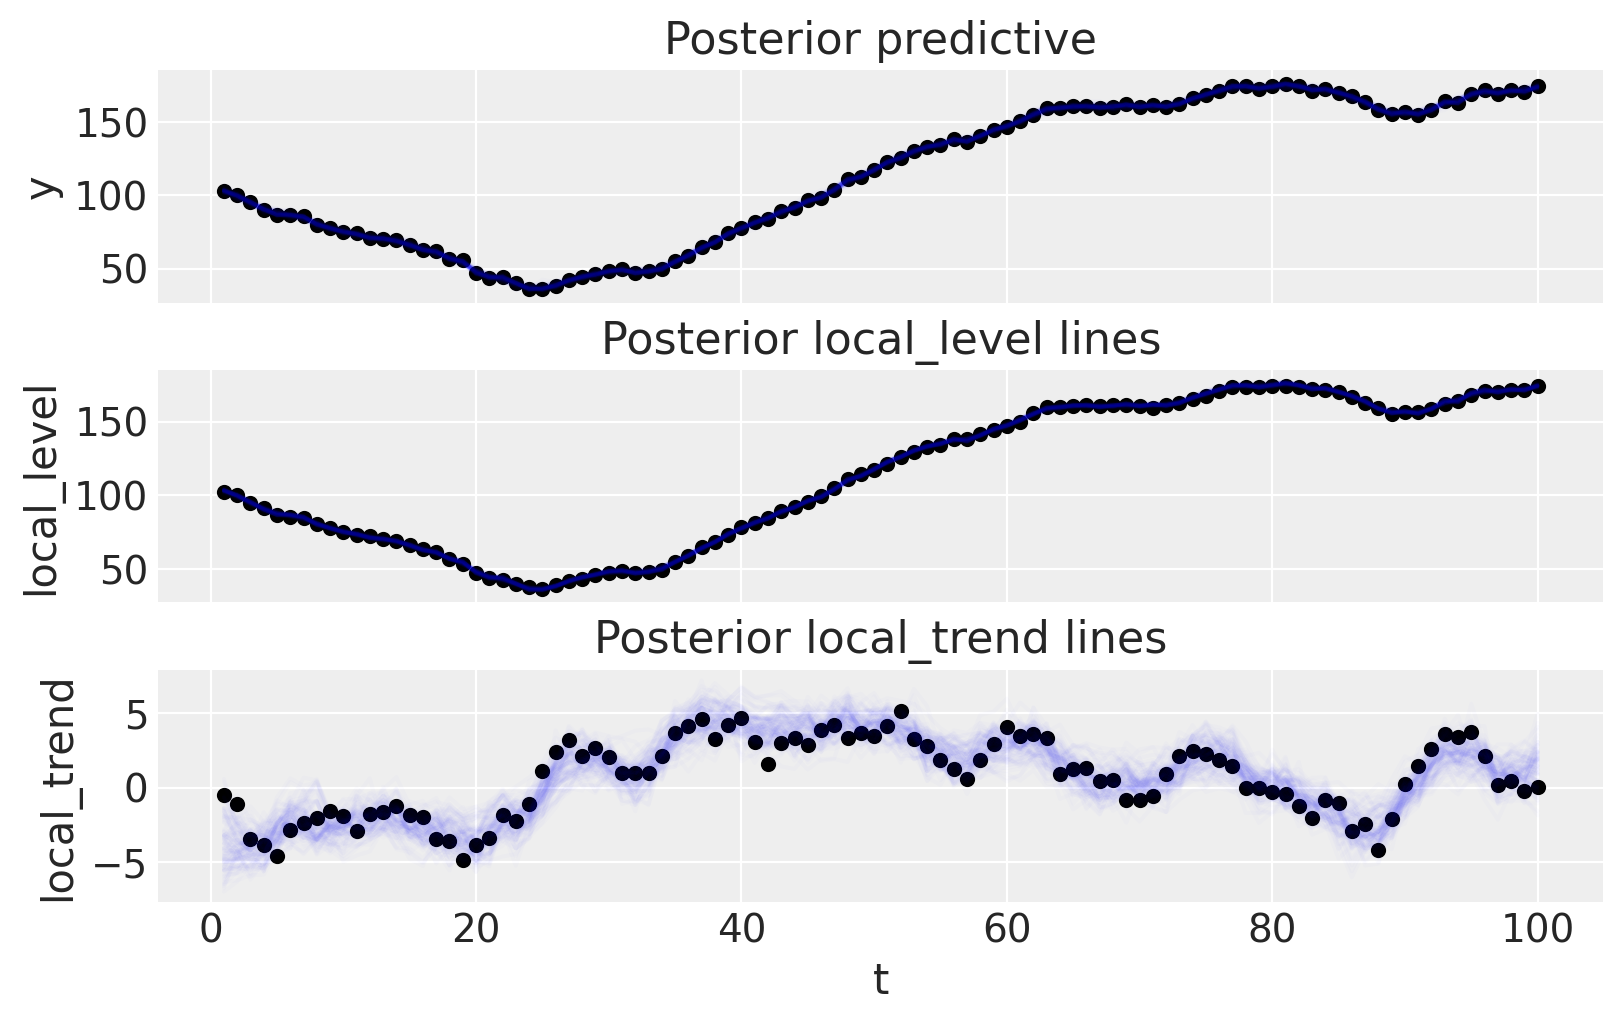

In [80]:

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(ppc, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["t"],
    az.extract(idata, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Posterior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(idata, group="posterior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Posterior local_trend lines");

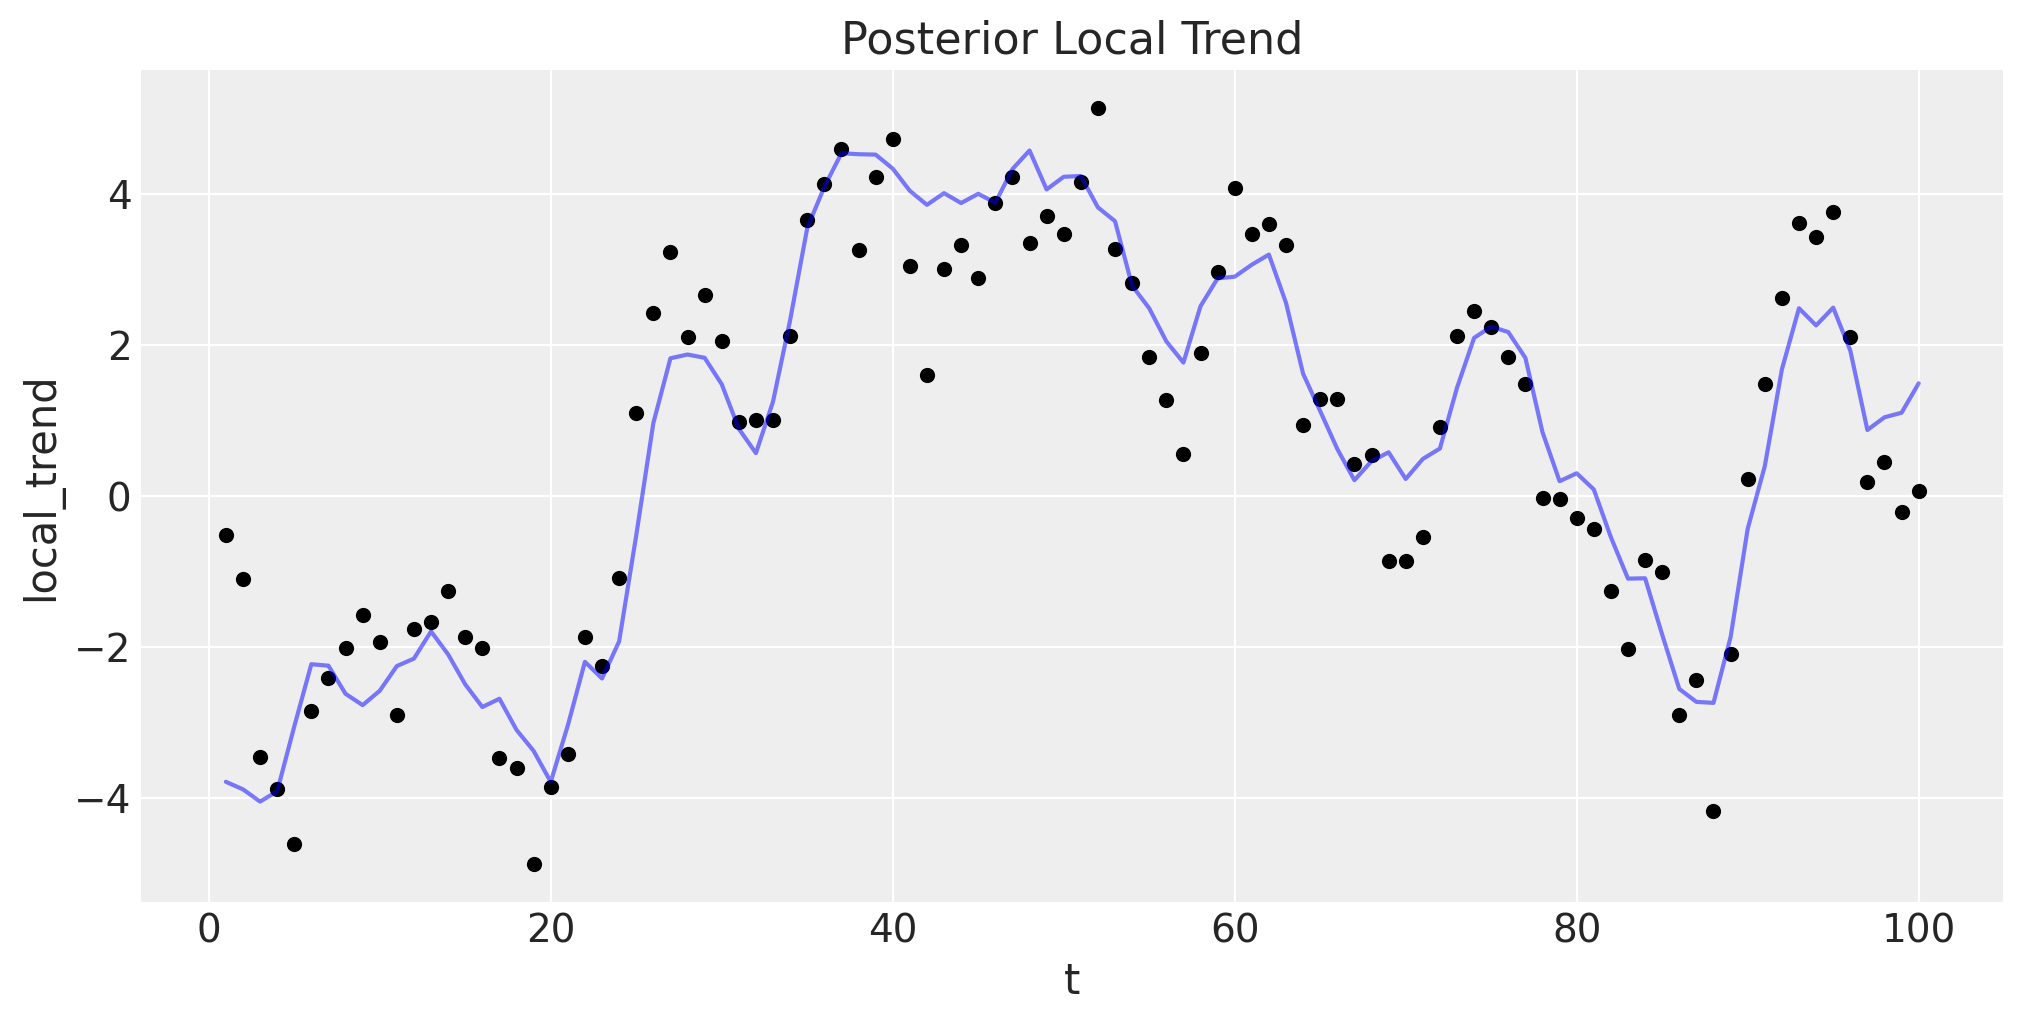

In [81]:
posterior_avg_trend = y_max*idata.posterior['local_trend'].mean(dim=['chain', 'draw'])
posterior_avg_trend

# plot ppc_avg_trend and y vs t
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["t"], posterior_avg_trend, color="blue", alpha=0.5)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax)
ax.set_title("Posterior Local Trend")
ax.set_ylabel("local_trend")
ax.set_xlabel("t");

In [98]:
az.summary(idata, var_names=['sigma_local_trend', 'sigma_local_level', 'local_trend_0', 'local_level_0', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma_local_trend  0.006  0.001   0.003    0.008        0.0      0.0   
sigma_local_level  0.008  0.003   0.003    0.012        0.0      0.0   
local_trend_0     -0.021  0.010  -0.041   -0.002        0.0      0.0   
local_level_0      0.609  0.013   0.584    0.634        0.0      0.0   
sigma              0.004  0.002   0.001    0.007        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
sigma_local_trend    2019.0    5821.0   1.00  
sigma_local_level     558.0     976.0   1.01  
local_trend_0       14430.0   26324.0   1.00  
local_level_0        7116.0    4541.0   1.00  
sigma                 358.0     170.0   1.02

In [99]:
az.summary(ppc, var_names=['y_obs'])

c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
y_obs[0]   0.588  0.006   0.577    0.600        0.0      0.0   55958.0   
y_obs[1]   0.570  0.006   0.558    0.581        0.0      0.0   13878.0   
y_obs[2]   0.542  0.006   0.531    0.553        0.0      0.0   42940.0   
y_obs[3]   0.520  0.006   0.509    0.531        0.0      0.0   61135.0   
y_obs[4]   0.498  0.006   0.487    0.510        0.0      0.0   19589.0   
...          ...    ...     ...      ...        ...      ...       ...   
y_obs[95]  0.970  0.006   0.959    0.982        0.0      0.0   23286.0   
y_obs[96]  0.982  0.006   0.970    0.993        0.0      0.0    3597.0   
y_obs[97]  0.976  0.006   0.965    0.989        0.0      0.0    3358.0   
y_obs[98]  0.988  0.006   0.977    1.000        0.0      0.0   60390.0   
y_obs[99]  0.999  0.006   0.987    1.011        0.0      0.0   58604.0   

           ess_tail  r_hat  
y_obs[0]    18718.0    1.0  
y_obs[1]    15423.0    1.0  
y_obs[2]    21561.0    1.0  
y_obs[3]    25581.0    1.0  
y_obs[4]    18073.0    1.0  
...             ...    ...  
y_obs[95]   15930.0    1.0  
y_obs[96]   12653.0    1.0  
y_obs[97]   11524.0    1.0  
y_obs[98]   26316.0    1.0  
y_obs[99]   18201.0    1.0  

[100 rows x 9 columns]

In [29]:
0.004 * 940

3.7600000000000002

### Alternativa que no funciona

In [114]:
coords = {'n_obs': df.index}

with pm.Model(coords=coords, check_bounds=True) as stochastic_trend_model_2:

    # Define the standard deviation for the trend, level and signal noises
    sigma_local_trend = pm.HalfNormal('sigma_local_trend', sigma=20)
    sigma_local_level = pm.HalfNormal('sigma_local_level', sigma=20)
    sigma       = pm.HalfNormal('sigma', sigma=.1)

    # Define the Gaussian Random Walk for the trend
    local_trend = pm.GaussianRandomWalk(
        name  = 'local_trend', 
        sigma = sigma_local_trend, 
        dims  = 'n_obs', 
        # init_dist = pm.Normal.dist(mu=0, sigma=1),
        )

    # Define the level as the trend plus Gaussian noise
    local_level = pm.GaussianRandomWalk(
        name  = 'local_level', 
        # mu    = local_trend, # Este es el que da problemas
        sigma = sigma_local_level, 
        dims  = 'n_obs', 
        # init_dist = pm.Normal.dist(mu=0, sigma=1),
        ) + local_trend
    
    # Likelihood
    y_obs = pm.Normal(
        name     =  "y_obs", 
        mu       = local_level, 
        sigma    = sigma, 
        # dims     = "n_obs", 
        observed = y,
        )
    
    stochastic_trend_prior2 = pm.sample_prior_predictive()


c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Sampling: [local_level, local_trend, sigma, sigma_local_level, sigma_local_trend, y_obs]


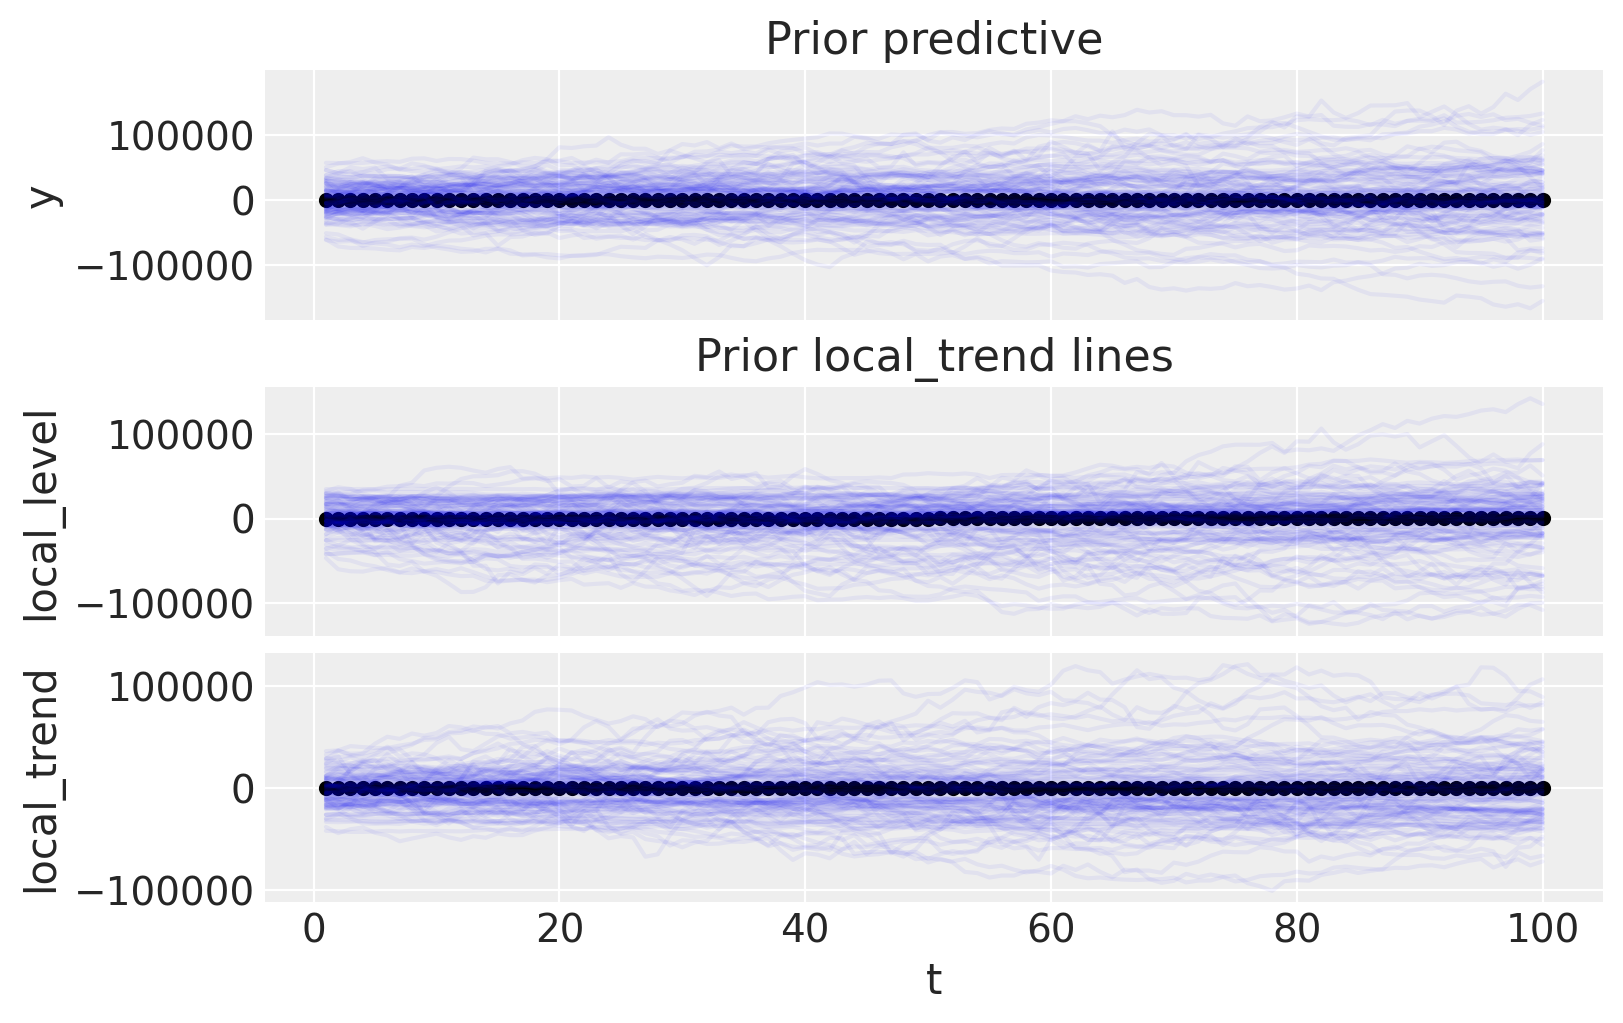

In [108]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior_predictive", num_samples=100)["y_obs"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[1].set_title("Prior local_trend lines");

In [115]:
RANDOM_SEED = 99999
rng = np.random.default_rng(RANDOM_SEED)

with stochastic_trend_model_2:
    idata2 = pm.sample(
        return_inferencedata=True, 
        # target_accept=0.9,
        draws=3000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True},
        )
    ppc2 = pm.sample_posterior_predictive(trace=idata2)

Compiling...
Compilation time =  0:00:05.095162
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]
















Running chain 0:   0%|          | 0/4000 [00:05<?, ?it/s]





Running chain 0:   5%|▌         | 200/4000 [00:05<00:12, 292.69it/s]




Running chain 0:  10%|█         | 400/4000 [00:06<00:14, 240.76it/s]





Running chain 0:  15%|█▌        | 600/4000 [00:07<00:16, 208.24it/s]





Running chain 0:  20%|██        | 800/4000 [00:09<00:18, 171.28it/s]





Running chain 0:  25%|██▌       | 1000/4000 [00:11<00:23, 129.44it/s]




Running chain 0:  30%|███       | 1200/4000 [00:12<00:20, 134.77it/s]


Running chain 0:  35%|███▌      | 1400/4000 [00:13<00:17, 152.30it/s]



Running chain 0:  40%|████      | 1600/4000 [00:15<00:15, 158.63it/s]

Running chain 0:  45%|████▌     | 1800/4000 [00:15<00:12, 179.27it/s]





Running chain 0:  50%|█████     | 2000/4000 [00:17<00:11, 175.92it/s]




Running chain 0:  55%|█████▌    | 2200/4000 [00:18<00:10, 178.04it/s]


Running chain 0:  60%|██████    | 2400/4000 [00:19<00:09, 17

Sampling time =  0:00:33.549584
Transforming variables...
Transformation time =  0:00:00.163611
Computing Log Likelihood...


Sampling: [y_obs]


Log Likelihood time =  0:00:00.441393


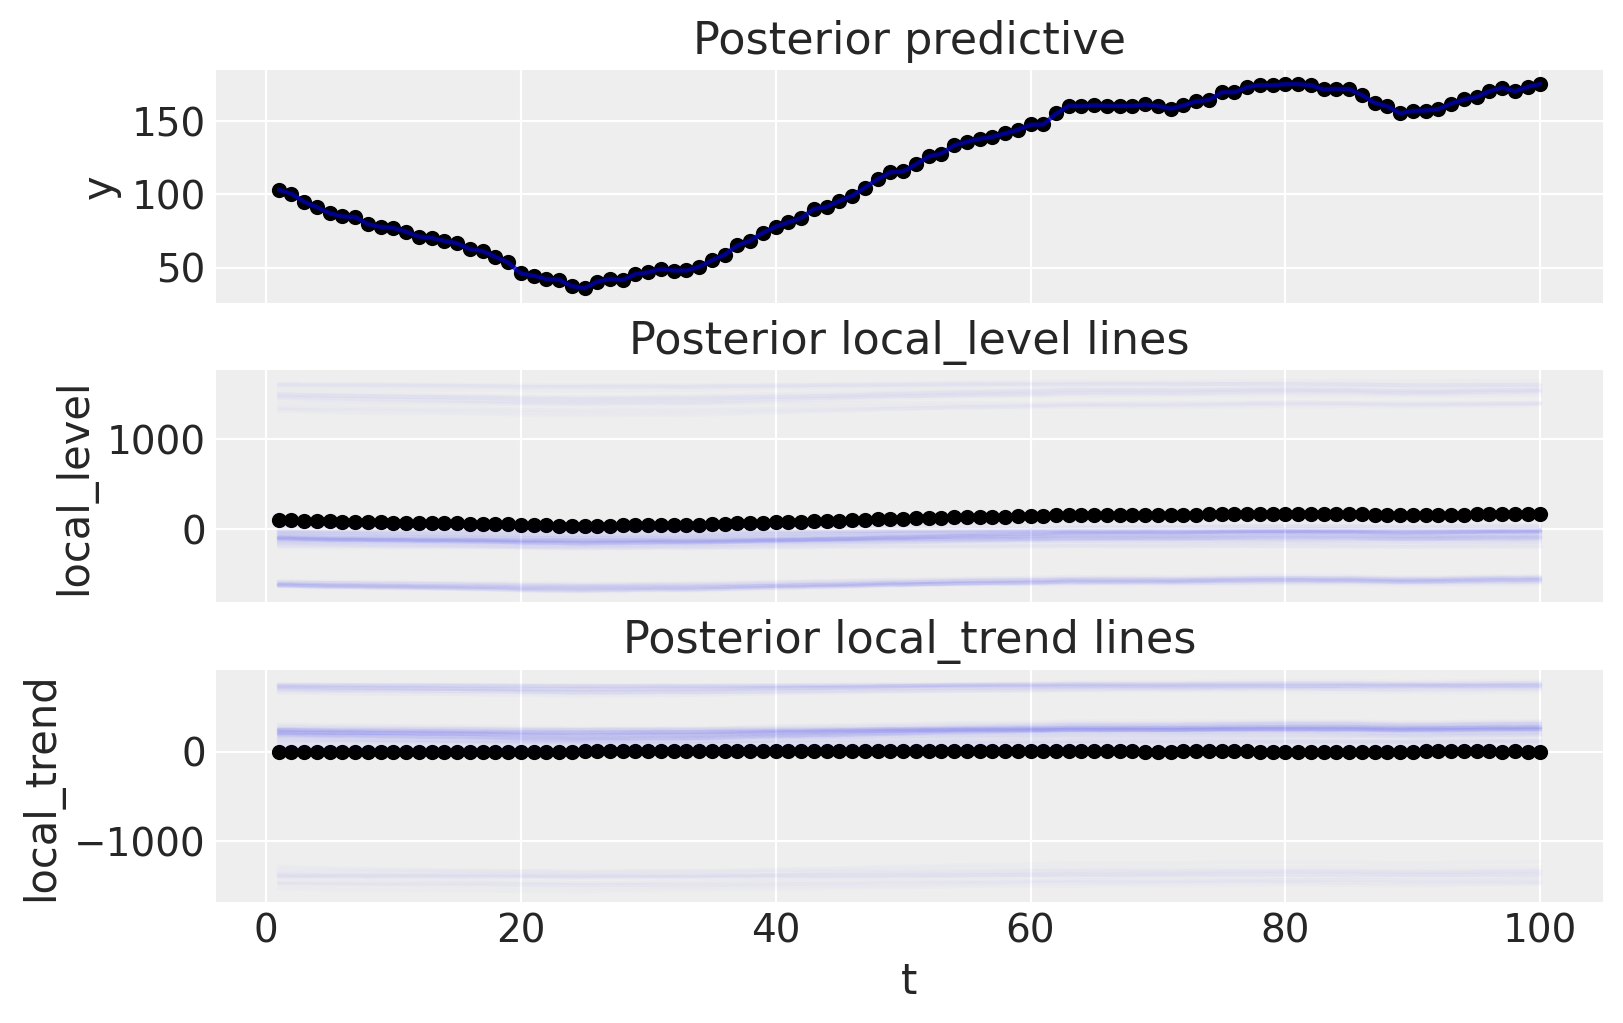

In [110]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(ppc2, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["t"],
    az.extract(idata2, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Posterior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(idata2, group="posterior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Posterior local_trend lines");

In [111]:
idata2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

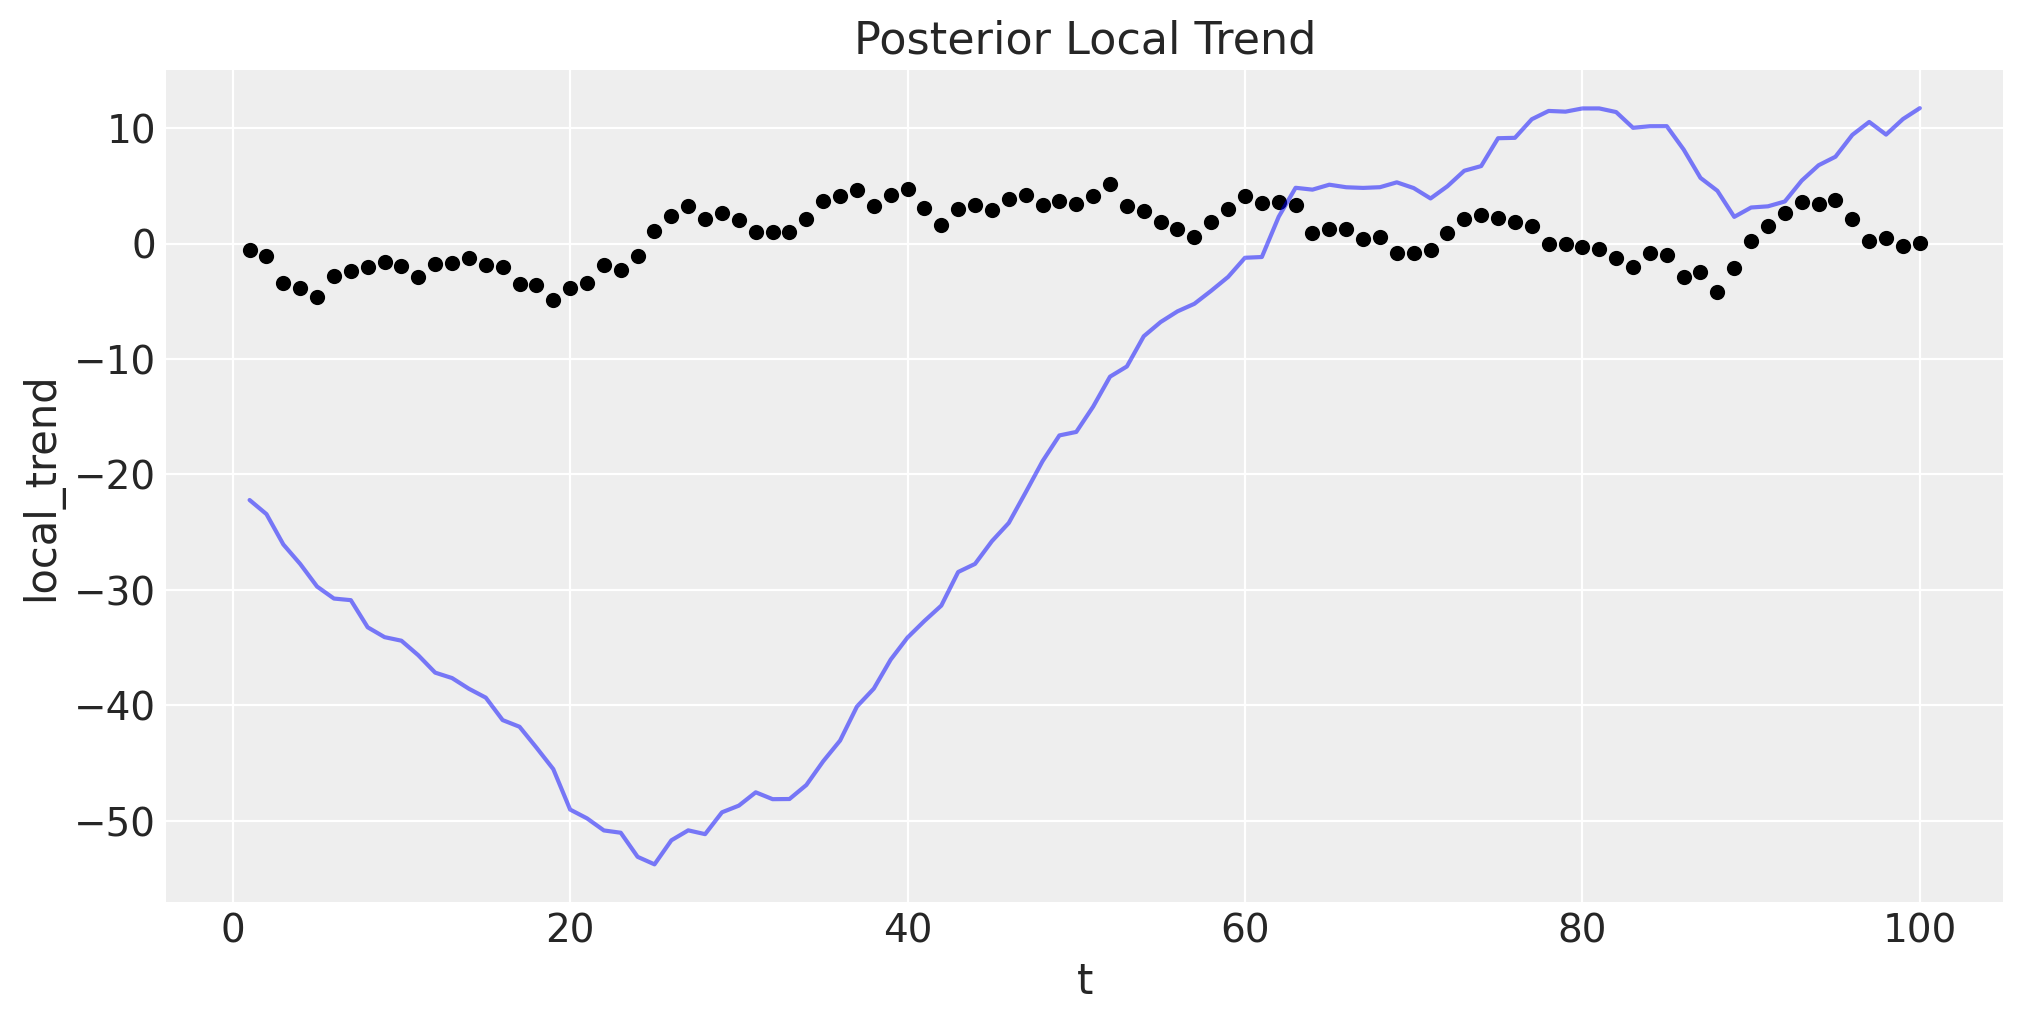

In [112]:
posterior_avg_trend2 = y_max*idata2.posterior['local_trend'].mean(dim=['chain', 'draw'])
posterior_avg_trend2

# plot ppc_avg_trend and y vs t
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["t"], posterior_avg_trend2, color="blue", alpha=0.5)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax)
ax.set_title("Posterior Local Trend")
ax.set_ylabel("local_trend")
ax.set_xlabel("t");

In [116]:
az.summary(idata2, var_names=['sigma_local_trend', 'sigma_local_level', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma_local_trend  0.012  0.005   0.003    0.020      0.001    0.001   
sigma_local_level  0.013  0.005   0.001    0.019      0.001    0.001   
sigma              0.002  0.001   0.000    0.003      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
sigma_local_trend      18.0      58.0   1.20  
sigma_local_level      17.0      17.0   1.21  
sigma                  25.0     145.0   1.16

In [119]:
az.summary(ppc2, var_names=['y_obs'])

c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
y_obs[0]   0.587  0.003   0.582    0.592        0.0      0.0   14396.0   
y_obs[1]   0.573  0.003   0.567    0.578        0.0      0.0   15152.0   
y_obs[2]   0.541  0.003   0.536    0.546        0.0      0.0   15153.0   
y_obs[3]   0.520  0.003   0.515    0.525        0.0      0.0   14361.0   
y_obs[4]   0.496  0.003   0.491    0.502        0.0      0.0   14851.0   
...          ...    ...     ...      ...        ...      ...       ...   
y_obs[95]  0.972  0.003   0.967    0.977        0.0      0.0   13903.0   
y_obs[96]  0.986  0.003   0.980    0.991        0.0      0.0   13117.0   
y_obs[97]  0.972  0.003   0.967    0.978        0.0      0.0   13816.0   
y_obs[98]  0.988  0.003   0.983    0.993        0.0      0.0   14444.0   
y_obs[99]  1.000  0.003   0.995    1.005        0.0      0.0   14946.0   

           ess_tail  r_hat  
y_obs[0]     1939.0   1.05  
y_obs[1]     1885.0   1.05  
y_obs[2]     2273.0   1.04  
y_obs[3]     2093.0   1.05  
y_obs[4]     2099.0   1.04  
...             ...    ...  
y_obs[95]    2002.0   1.04  
y_obs[96]    1737.0   1.04  
y_obs[97]    1823.0   1.05  
y_obs[98]    2272.0   1.05  
y_obs[99]    2136.0   1.05  

[100 rows x 9 columns]

## Seasonality

In [28]:
df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

df = pd.concat([df, fourier_features], axis = 1)
df['yr_season'] = np.dot(fourier_features, fourier_coefs)
df['y'] = df['yr_season'] + rng.normal(0, 1, df.shape[0])
df.head()

fecha  sin_order_1  cos_order_1  sin_order_2  cos_order_2  yr_season  \
0 2021-01-01    -0.004301     0.999991    -0.008601     0.999963   1.987052   
1 2021-01-02     0.012901     0.999917     0.025801     0.999667   2.038286   
2 2021-01-03     0.030100     0.999547     0.060172     0.998188   2.088007   
3 2021-01-04     0.047289     0.998881     0.094472     0.995527   2.136170   
4 2021-01-05     0.064464     0.997920     0.128661     0.991689   2.182734   

          y  
0  1.594930  
1  2.143587  
2  1.544414  
3  3.270610  
4  1.024933

<Axes: xlabel='fecha'>

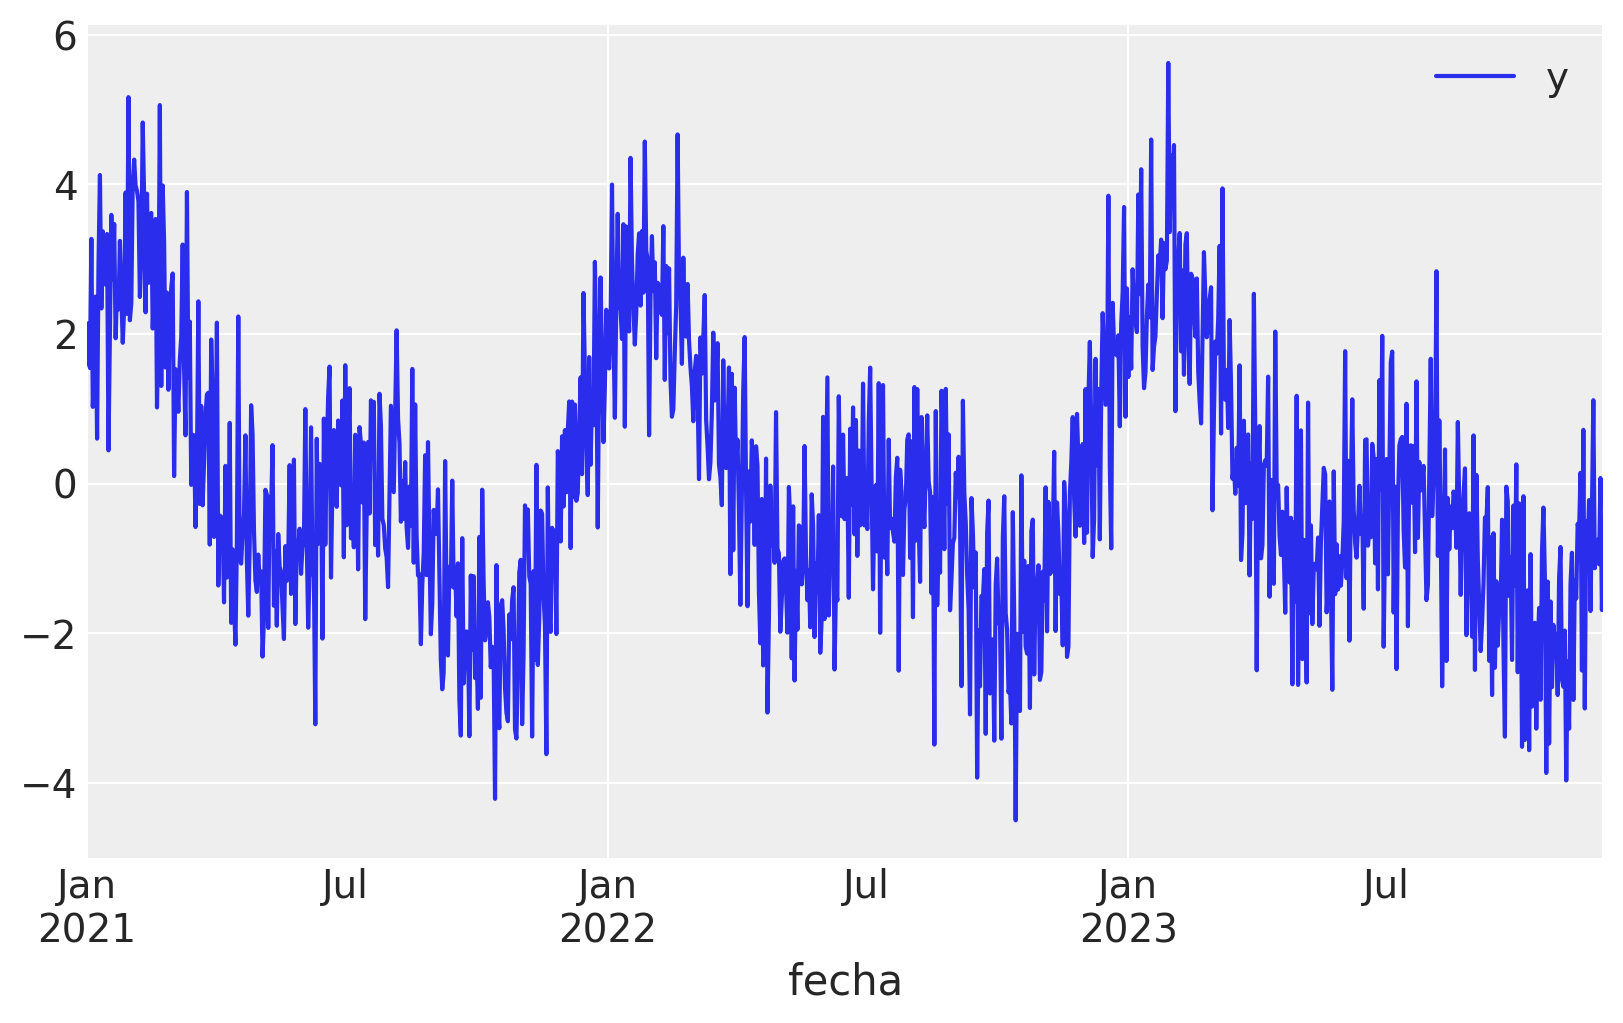

In [29]:
df.plot("fecha", "y")

### 0 - Scale the data

In [32]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

### 1 - Model

In [71]:
n_order = 2

coords = {'n_obs': df['fecha'],
          "fourier_features": np.arange(2 * n_order)}

with pm.Model(check_bounds=False, coords=coords) as seasonality_model:
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=0.5, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(beta_fourier, fourier_features.to_numpy().T),
        dims = "n_obs"
    )
    
    y_obs = pm.Normal("y_obs", mu=seasonality, sigma=sigma, observed=y, dims = "n_obs")

    seasonality_model_prior = pm.sample_prior_predictive()

Sampling: [beta_fourier, sigma, y_obs]


In [56]:
seasonality_model_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

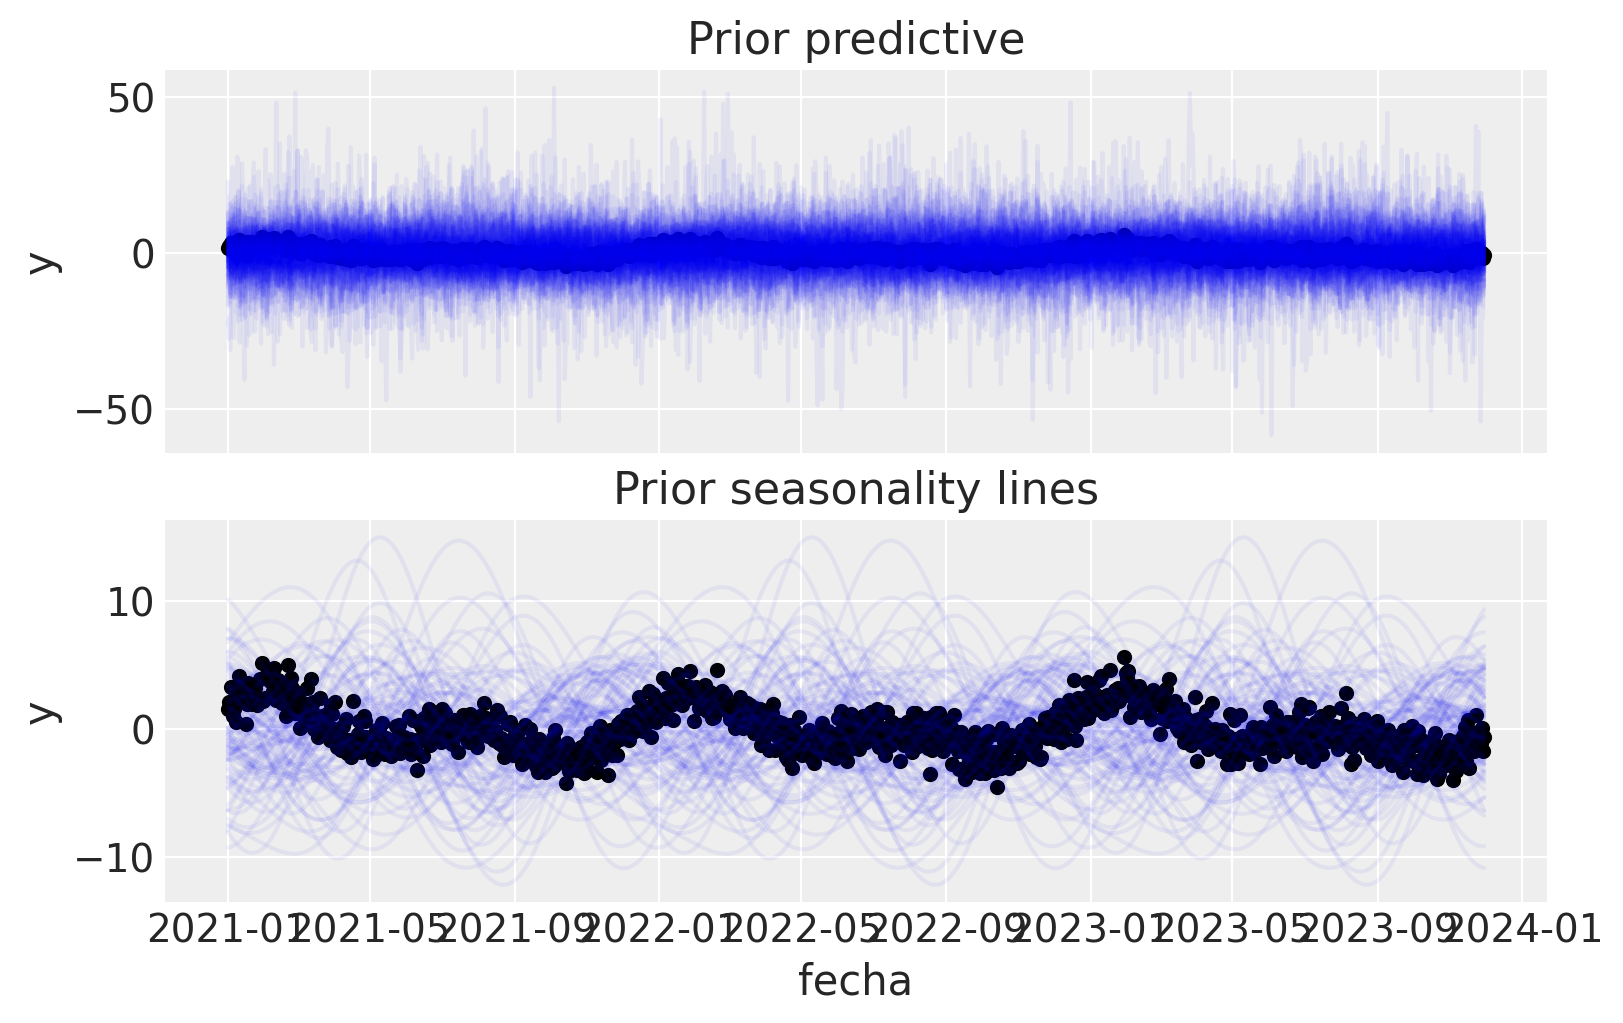

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(seasonality_model_prior, group="prior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(seasonality_model_prior, group="prior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Prior seasonality lines");

In [72]:
with seasonality_model:
    # inference data, trace, posterior
    idata_s = pm.sample(
        return_inferencedata=True, 
        target_accept=0.9,
        draws=12000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    ppc_s = pm.sample_posterior_predictive(trace=idata_s)

Compiling...
Compilation time =  0:00:02.571520
Sampling...


Compiling.. :   0%|          | 0/13000 [00:00<?, ?it/s]
















Running chain 0:   0%|          | 0/13000 [00:05<?, ?it/s]






Running chain 0:  15%|█▌        | 1950/13000 [00:05<00:00, 14130.29it/s]





Running chain 0:  30%|███       | 3900/13000 [00:05<00:00, 14677.60it/s]





Running chain 0:  45%|████▌     | 5850/13000 [00:05<00:00, 14907.53it/s]





Running chain 0:  55%|█████▌    | 7150/13000 [00:05<00:00, 14082.59it/s]





Running chain 0:  65%|██████▌   | 8450/13000 [00:06<00:00, 13202.26it/s]





Running chain 0:  75%|███████▌  | 9750/13000 [00:06<00:00, 12245.12it/s]




Running chain 0:  85%|████████▌ | 11050/13000 [00:06<00:00, 12210.64it/s]





Running chain 4: 100%|██████████| 13000/13000 [00:06<00:00, 2037.87it/s] 


Sampling time =  0:00:06.805609
Transforming variables...
Transformation time =  0:00:00.882319
Computing Log Likelihood...
Log Likelihood time =  0:00:00.877010


Sampling: [y_obs]


In [60]:
idata_s

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [61]:
ppc_s

Inference data with groups:
	> posterior_predictive
	> observed_data

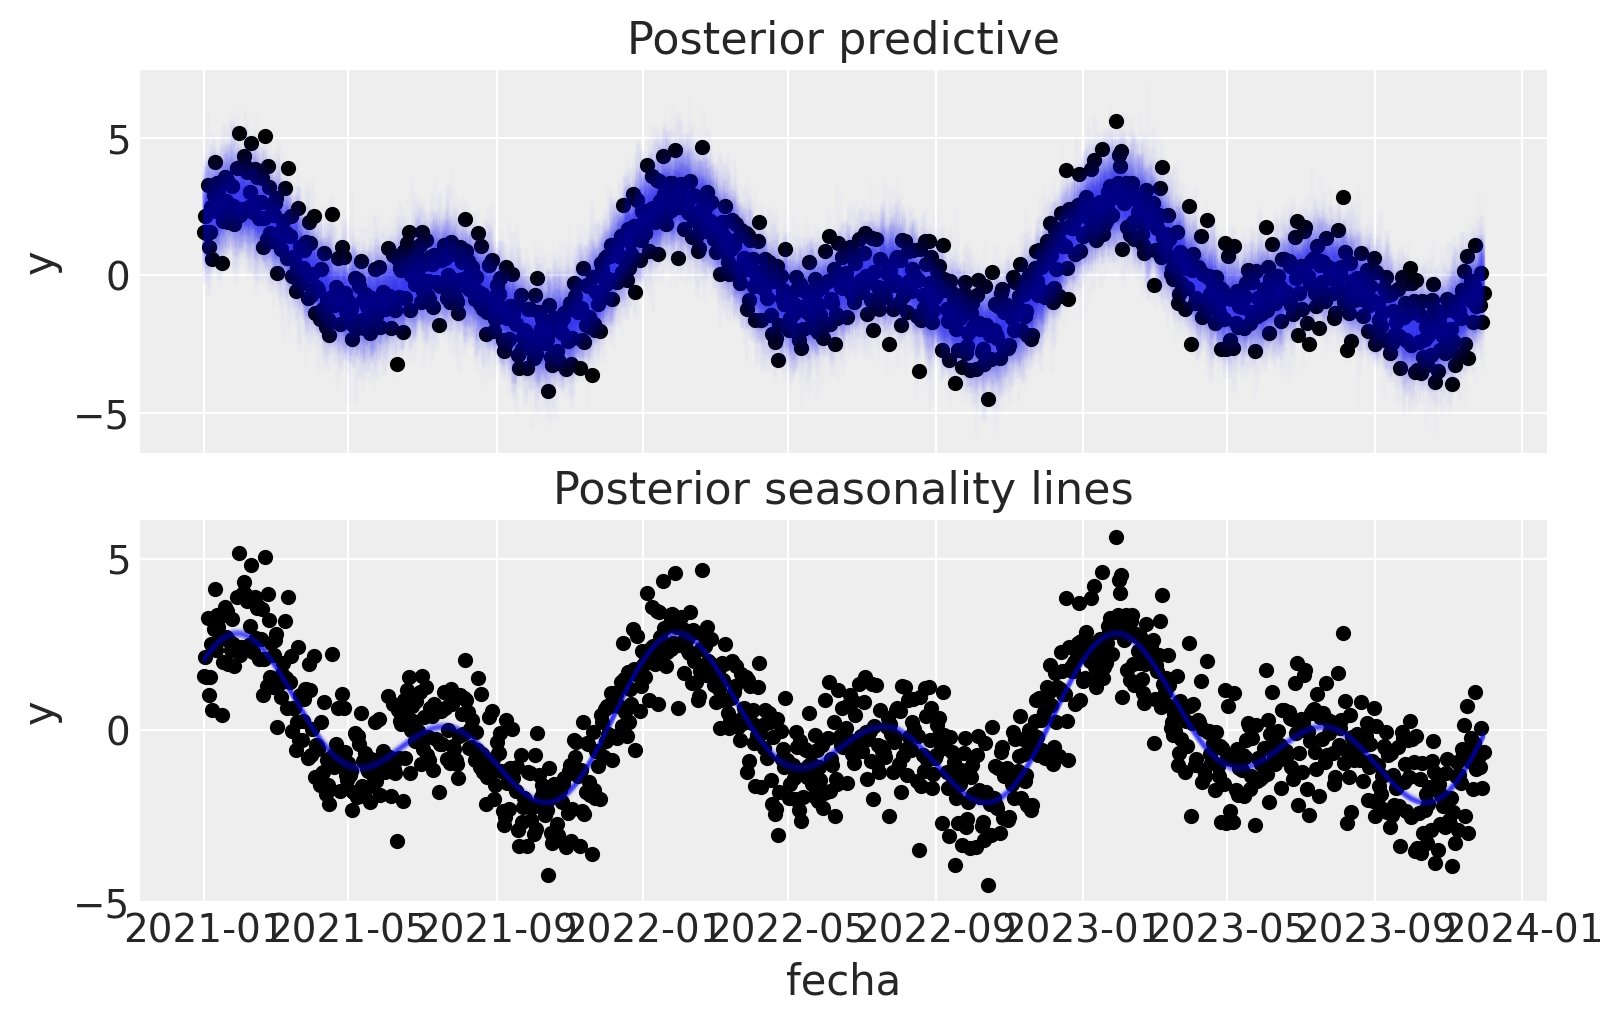

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(ppc_s, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(idata_s, group="posterior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior seasonality lines");

In [64]:
az.summary(idata_s, var_names=['beta_fourier', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_fourier[0]  0.179  0.008   0.165    0.193        0.0      0.0   82396.0   
beta_fourier[1]  0.188  0.008   0.173    0.202        0.0      0.0   83217.0   
beta_fourier[2]  0.182  0.008   0.168    0.196        0.0      0.0   80898.0   
beta_fourier[3]  0.181  0.008   0.166    0.195        0.0      0.0   83815.0   
sigma            0.176  0.004   0.169    0.183        0.0      0.0   81540.0   

                 ess_tail  r_hat  
beta_fourier[0]   44696.0    1.0  
beta_fourier[1]   45741.0    1.0  
beta_fourier[2]   44989.0    1.0  
beta_fourier[3]   44799.0    1.0  
sigma             44919.0    1.0

In [65]:
0.179*y_max

1.0063335287714141

In [73]:
res = az.summary(ppc_s, var_names=['y_obs'])

c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


In [74]:
res

mean     sd  hdi_3%  hdi_97%  \
y_obs[2021-01-01T00:00:00.000000000]  0.367  0.176   0.030    0.694   
y_obs[2021-01-02T00:00:00.000000000]  0.375  0.177   0.039    0.702   
y_obs[2021-01-03T00:00:00.000000000]  0.384  0.177   0.053    0.717   
y_obs[2021-01-04T00:00:00.000000000]  0.393  0.176   0.062    0.725   
y_obs[2021-01-05T00:00:00.000000000]  0.401  0.176   0.072    0.731   
...                                     ...    ...     ...      ...   
y_obs[2023-11-26T00:00:00.000000000] -0.077  0.175  -0.416    0.240   
y_obs[2023-11-27T00:00:00.000000000] -0.063  0.177  -0.394    0.269   
y_obs[2023-11-28T00:00:00.000000000] -0.052  0.176  -0.385    0.275   
y_obs[2023-11-29T00:00:00.000000000] -0.039  0.176  -0.369    0.293   
y_obs[2023-11-30T00:00:00.000000000] -0.027  0.175  -0.361    0.298   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
y_obs[2021-01-01T00:00:00.000000000]      0.001    0.001   59083.0   58722.0   
y_obs[2021-01-02T00:00:00.000000000]      0.001    0.001   60440.0   60309.0   
y_obs[2021-01-03T00:00:00.000000000]      0.001    0.001   59382.0   59391.0   
y_obs[2021-01-04T00:00:00.000000000]      0.001    0.001   59561.0   60186.0   
y_obs[2021-01-05T00:00:00.000000000]      0.001    0.001   59666.0   59712.0   
...                                         ...      ...       ...       ...   
y_obs[2023-11-26T00:00:00.000000000]      0.001    0.001   59890.0   57757.0   
y_obs[2023-11-27T00:00:00.000000000]      0.001    0.001   58962.0   59038.0   
y_obs[2023-11-28T00:00:00.000000000]      0.001    0.001   59509.0   59169.0   
y_obs[2023-11-29T00:00:00.000000000]      0.001    0.001   59915.0   59270.0   
y_obs[2023-11-30T00:00:00.000000000]      0.001    0.001   59084.0   59630.0   

                                      r_hat  
y_obs[2021-01-01T00:00:00.000000000]    1.0  
y_obs[2021-01-02T00:00:00.000000000]    1.0  
y_obs[2021-01-03T00:00:00.000000000]    1.0  
y_obs[2021-01-04T00:00:00.000000000]    1.0  
y_obs[2021-01-05T00:00:00.000000000]    1.0  
...                                     ...  
y_obs[2023-11-26T00:00:00.000000000]    1.0  
y_obs[2023-11-27T00:00:00.000000000]    1.0  
y_obs[2023-11-28T00:00:00.000000000]    1.0  
y_obs[2023-11-29T00:00:00.000000000]    1.0  
y_obs[2023-11-30T00:00:00.000000000]    1.0  

[1064 rows x 9 columns]

In [75]:
res['mean']*y_max

y_obs[2021-01-01T00:00:00.000000000]    2.063265
y_obs[2021-01-02T00:00:00.000000000]    2.108241
y_obs[2021-01-03T00:00:00.000000000]    2.158838
y_obs[2021-01-04T00:00:00.000000000]    2.209436
y_obs[2021-01-05T00:00:00.000000000]    2.254412
                                          ...   
y_obs[2023-11-26T00:00:00.000000000]   -0.432892
y_obs[2023-11-27T00:00:00.000000000]   -0.354184
y_obs[2023-11-28T00:00:00.000000000]   -0.292343
y_obs[2023-11-29T00:00:00.000000000]   -0.219257
y_obs[2023-11-30T00:00:00.000000000]   -0.151793
Name: mean, Length: 1064, dtype: float64

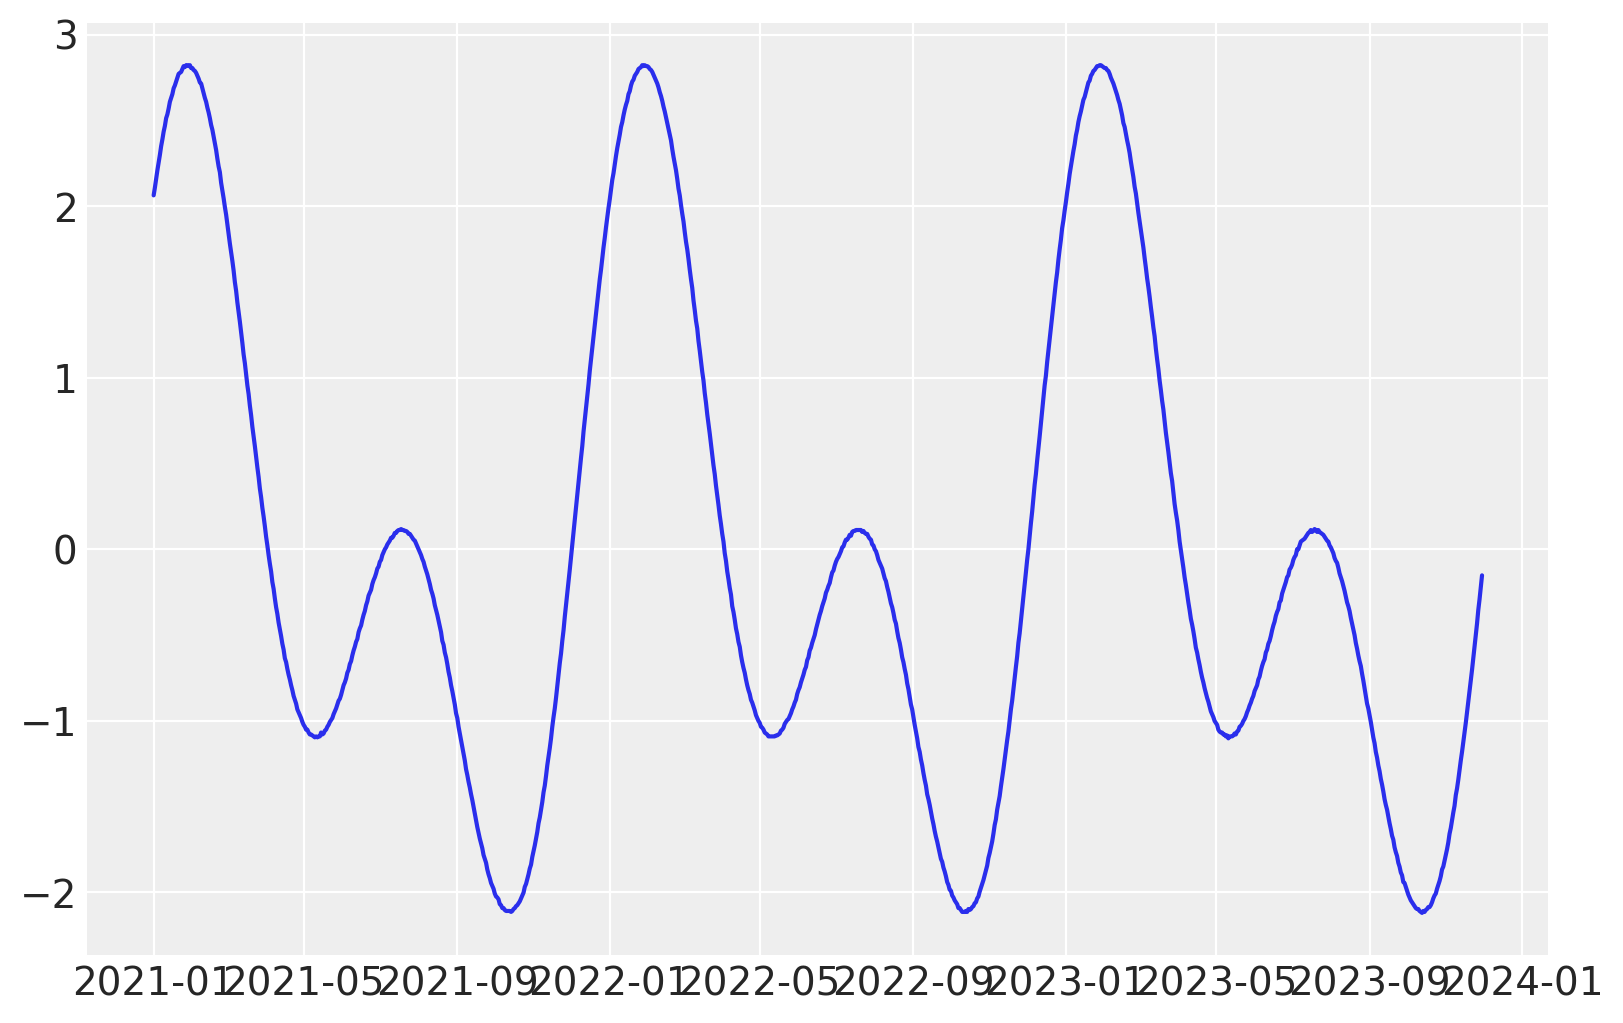

In [76]:
plt.plot(df["fecha"], res['mean']*y_max)

## Trend + Season

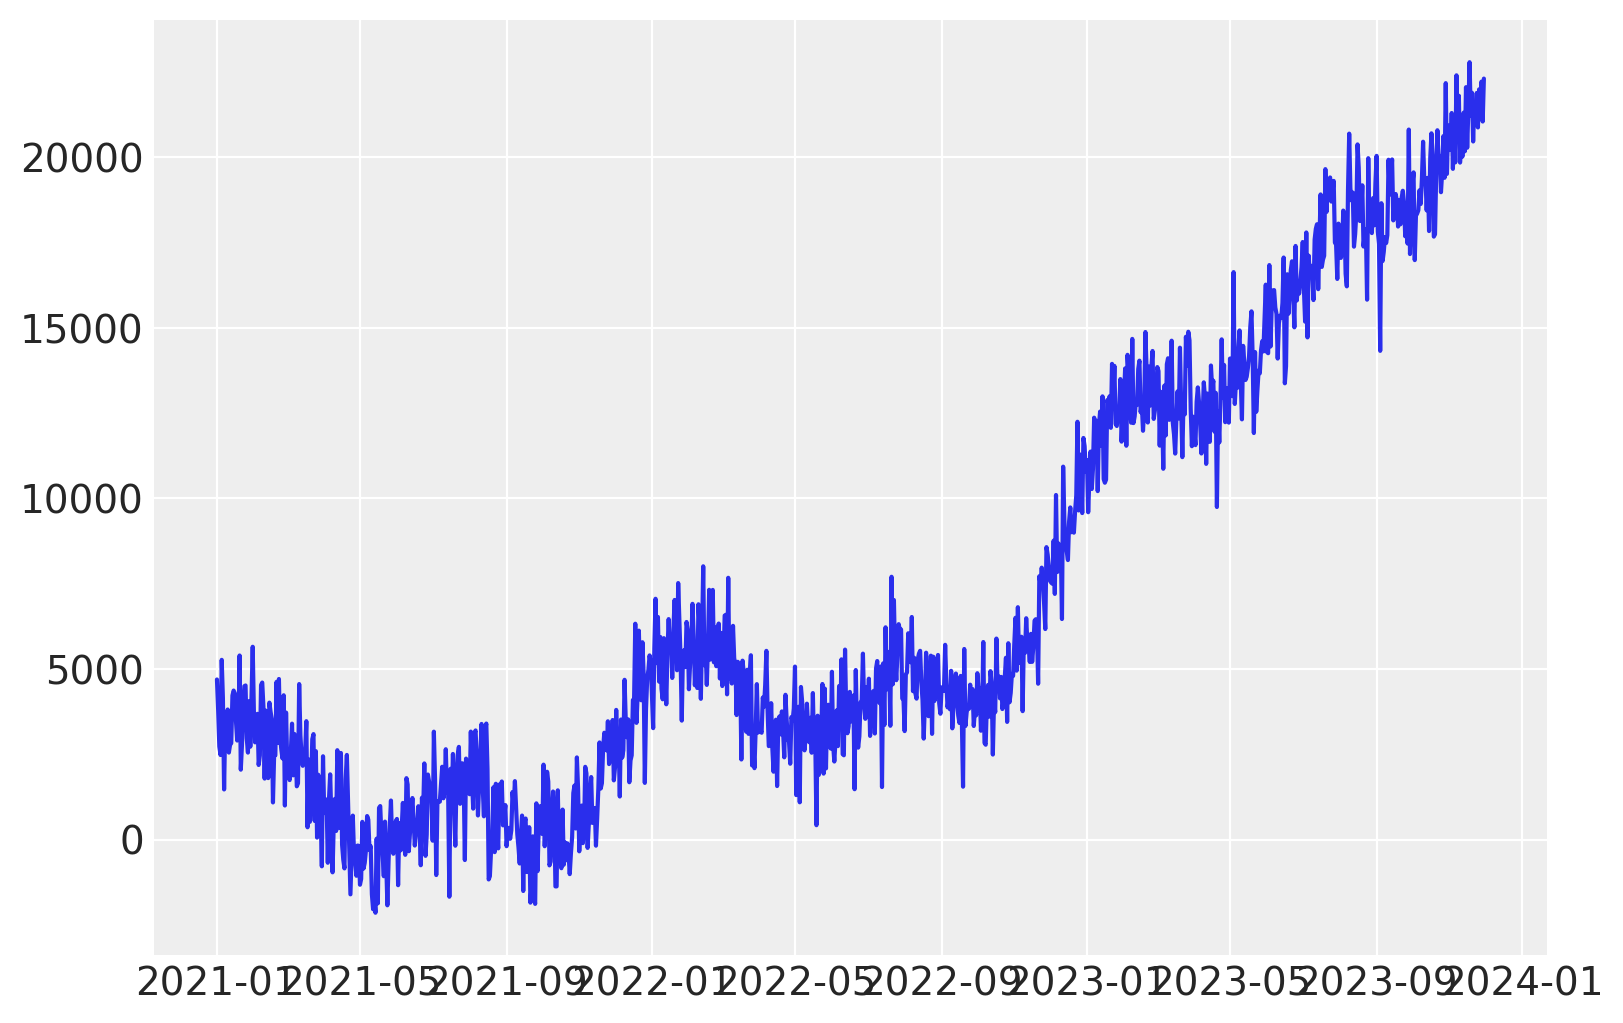

In [82]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

df = pd.concat([
    df, 
    stochastic_trend(
        rng, 
        N = df.shape[0], 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 1000
        )
    ], 
               axis = 1)

fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25)
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

df['yr_season'] = 1000 * np.dot(fourier_features, fourier_coefs)

df['y'] = df['local_level'] + df['yr_season'] + rng.normal(0, 1000, df.shape[0])

plt.plot(df["fecha"], df['y'])

In [83]:
df

fecha     t  local_trend   local_level    yr_season             y
0    2021-01-01     1    -0.521628    999.398528  1987.052064   4690.128014
1    2021-01-02     2    -1.095988    998.214240  2038.286110   3804.617002
2    2021-01-03     3    -3.458094    995.419512  2088.006727   2725.387279
3    2021-01-04     4    -3.890317    991.485024  2136.170004   2476.231599
4    2021-01-05     5    -4.609461    986.525422  2182.733604   5265.666414
...         ...   ...          ...           ...          ...           ...
1059 2023-11-26  1060    29.593822  22168.834477  -452.734374  21985.802995
1060 2023-11-27  1061    30.075970  22199.439153  -385.338443  21257.872629
1061 2023-11-28  1062    30.314250  22230.267329  -317.278867  22211.444626
1062 2023-11-29  1063    29.727088  22261.563491  -248.614932  21041.950852
1063 2023-11-30  1064    30.602816  22292.005876  -179.406710  22300.214989

[1064 rows x 6 columns]

In [84]:
# STL decomposition
from statsmodels.tsa.seasonal import STL


In [85]:
aux = df[['fecha', 'y']].copy()
aux.set_index('fecha', inplace=True, drop = True)
# The decomposition requires 1 input, the data series. If the data series does 
# not have a frequency, then you must also specify period. The default value for 
# seasonal is 7, and so should also be changed in most applications.
aux = aux.asfreq('D')


c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\statsmodels\tsa\seasonal.py:359: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


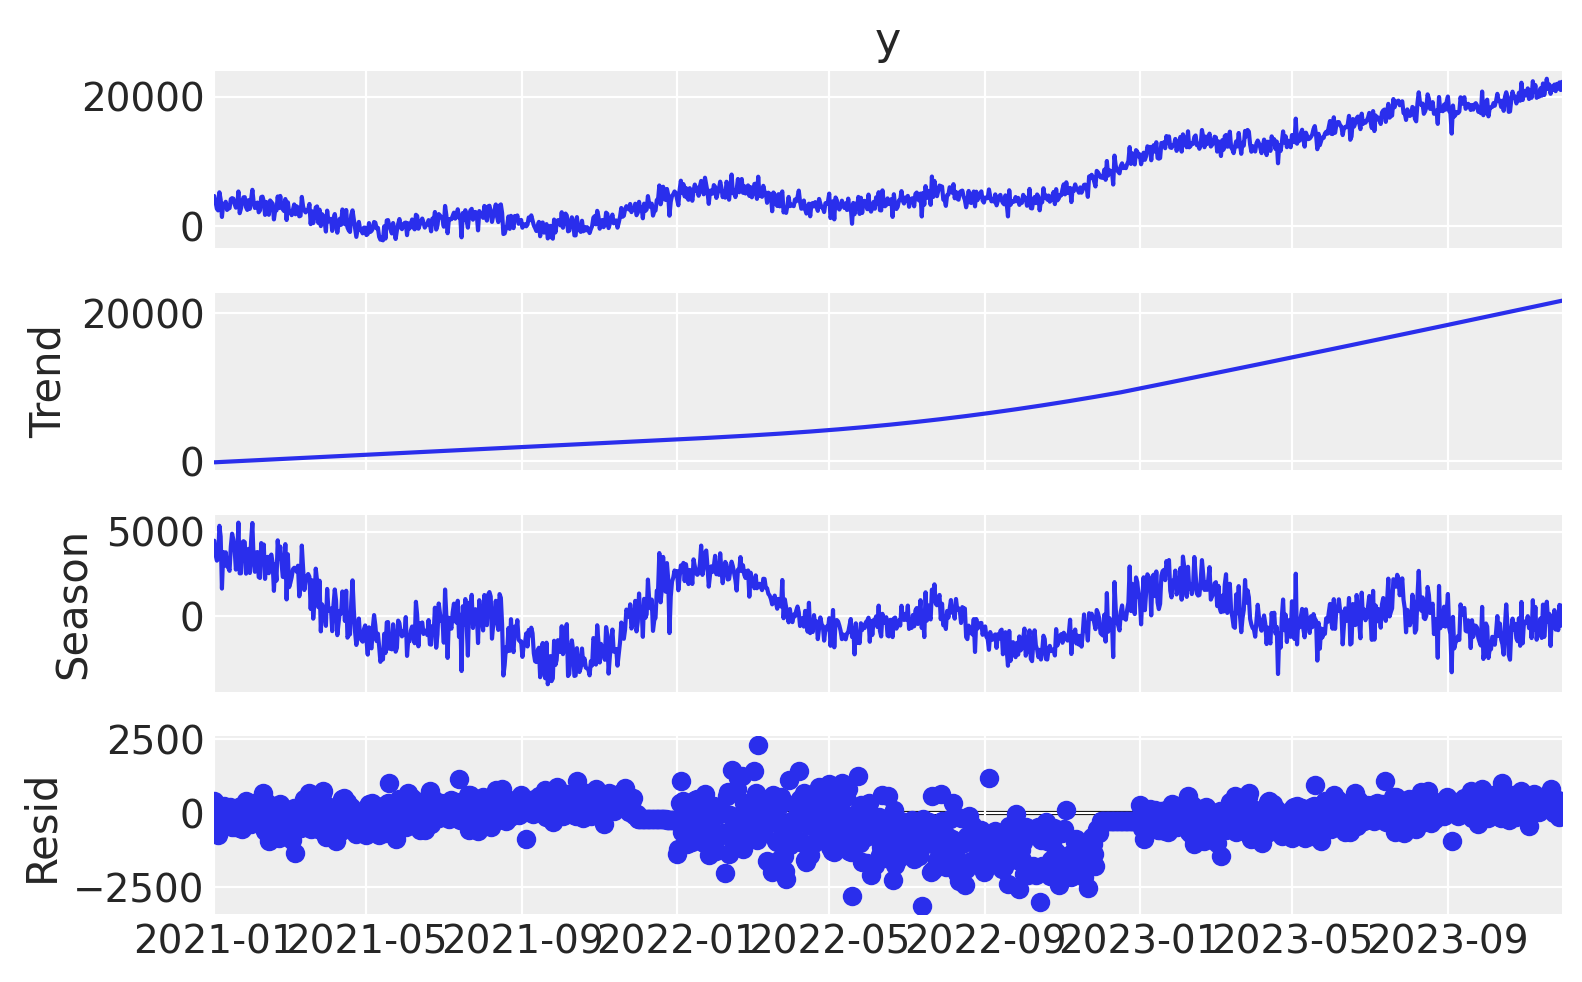

In [86]:
stl = STL(aux['y'], period=365)
res = stl.fit()
fig = res.plot()

### 0 - Scale the data

In [87]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

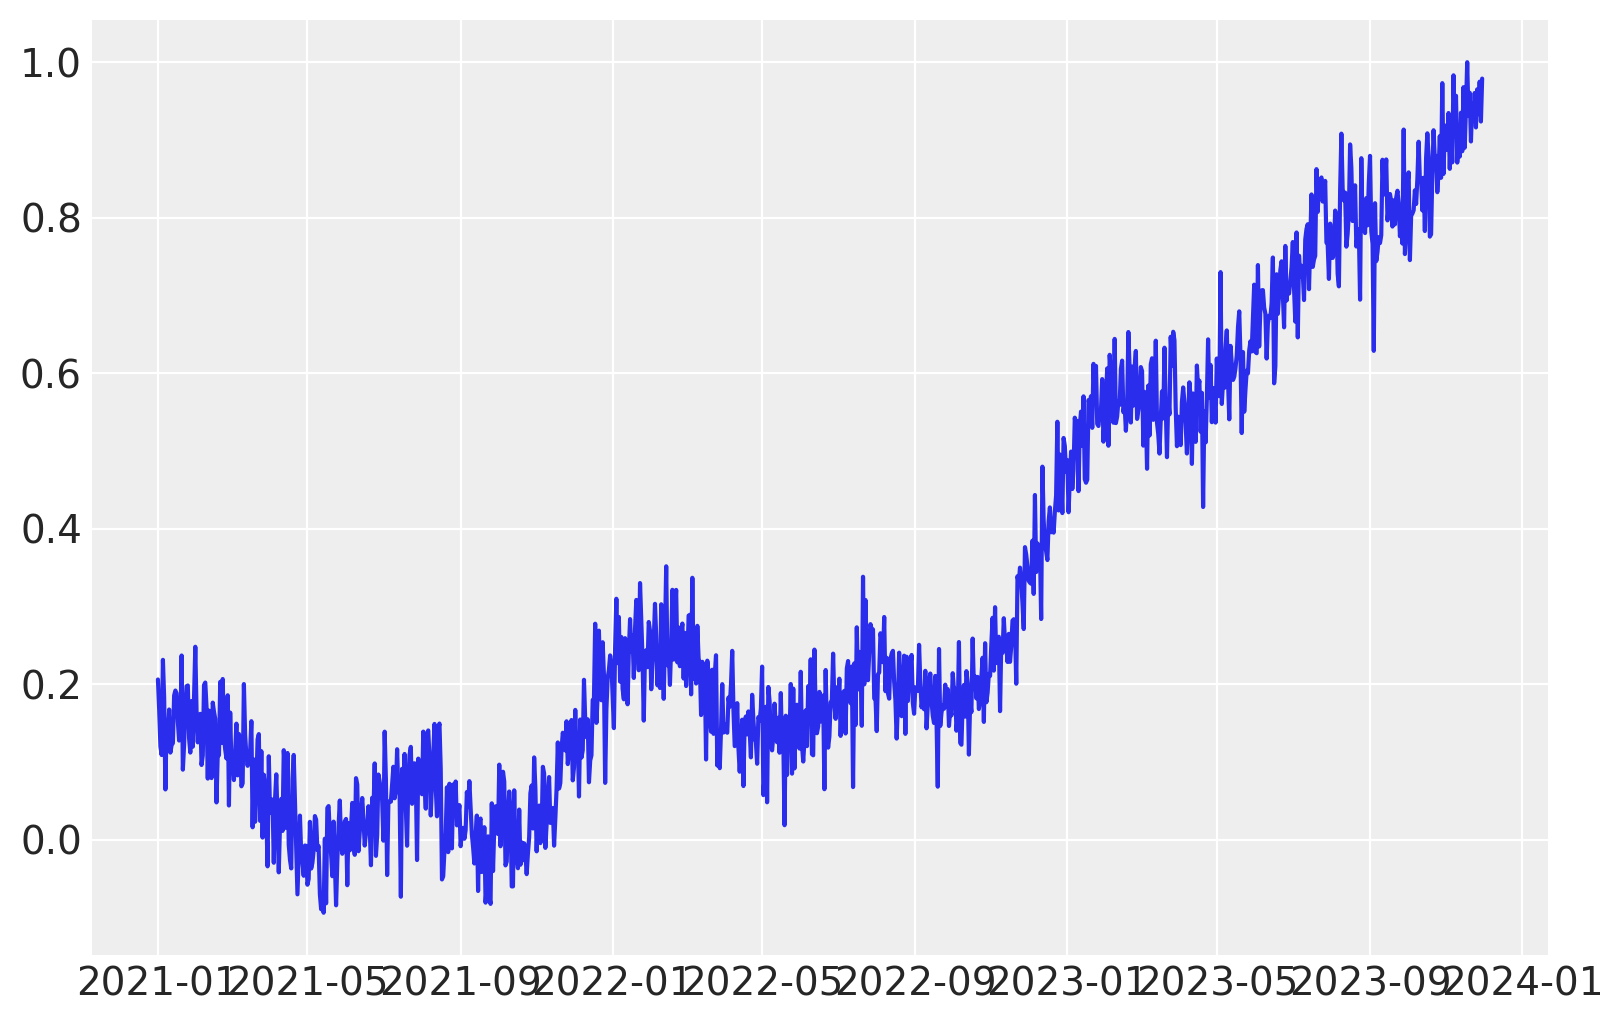

In [88]:
plt.plot(df["fecha"], y)

### 1 - Model

In [143]:
n_order = 2

coords = {'n_obs': df['fecha'],
          "fourier_features": np.arange(2 * n_order)}

with pm.Model(coords=coords, check_bounds=False) as trend_season_model:

    sigma_local_trend = pm.Exponential("sigma_local_trend", lam=y_max * 1)  # 20
    sigma_local_level = pm.Exponential("sigma_local_level", lam=y_max * 1)  # 20
    sigma             = pm.Exponential("sigma", lam=y_max * 1)              # .1

    local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=1e-1)
    diff_local_trend = pm.Normal("diff_local_trend", mu=0, sigma=sigma_local_trend, dims="n_obs")
    local_trend      = pm.Deterministic("local_trend", diff_local_trend.cumsum() + local_trend_0, dims="n_obs")
    
    local_level_0    = pm.Normal("local_level_0", mu=0, sigma=.5)
    diff_local_level = pm.Normal("diff_local_level", mu=local_trend, sigma=sigma_local_level, dims="n_obs")
    local_level      = pm.Deterministic("local_level", diff_local_level.cumsum() + local_level_0, dims="n_obs")
    
    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=.5, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(beta_fourier, fourier_features.to_numpy().T),
        dims = "n_obs"
    )
    
    mu = pm.Deterministic("mu", local_level + seasonality, dims = "n_obs")

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, dims="n_obs", observed=y)

    trend_season_prior = pm.sample_prior_predictive()

Sampling: [beta_fourier, diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y_obs]


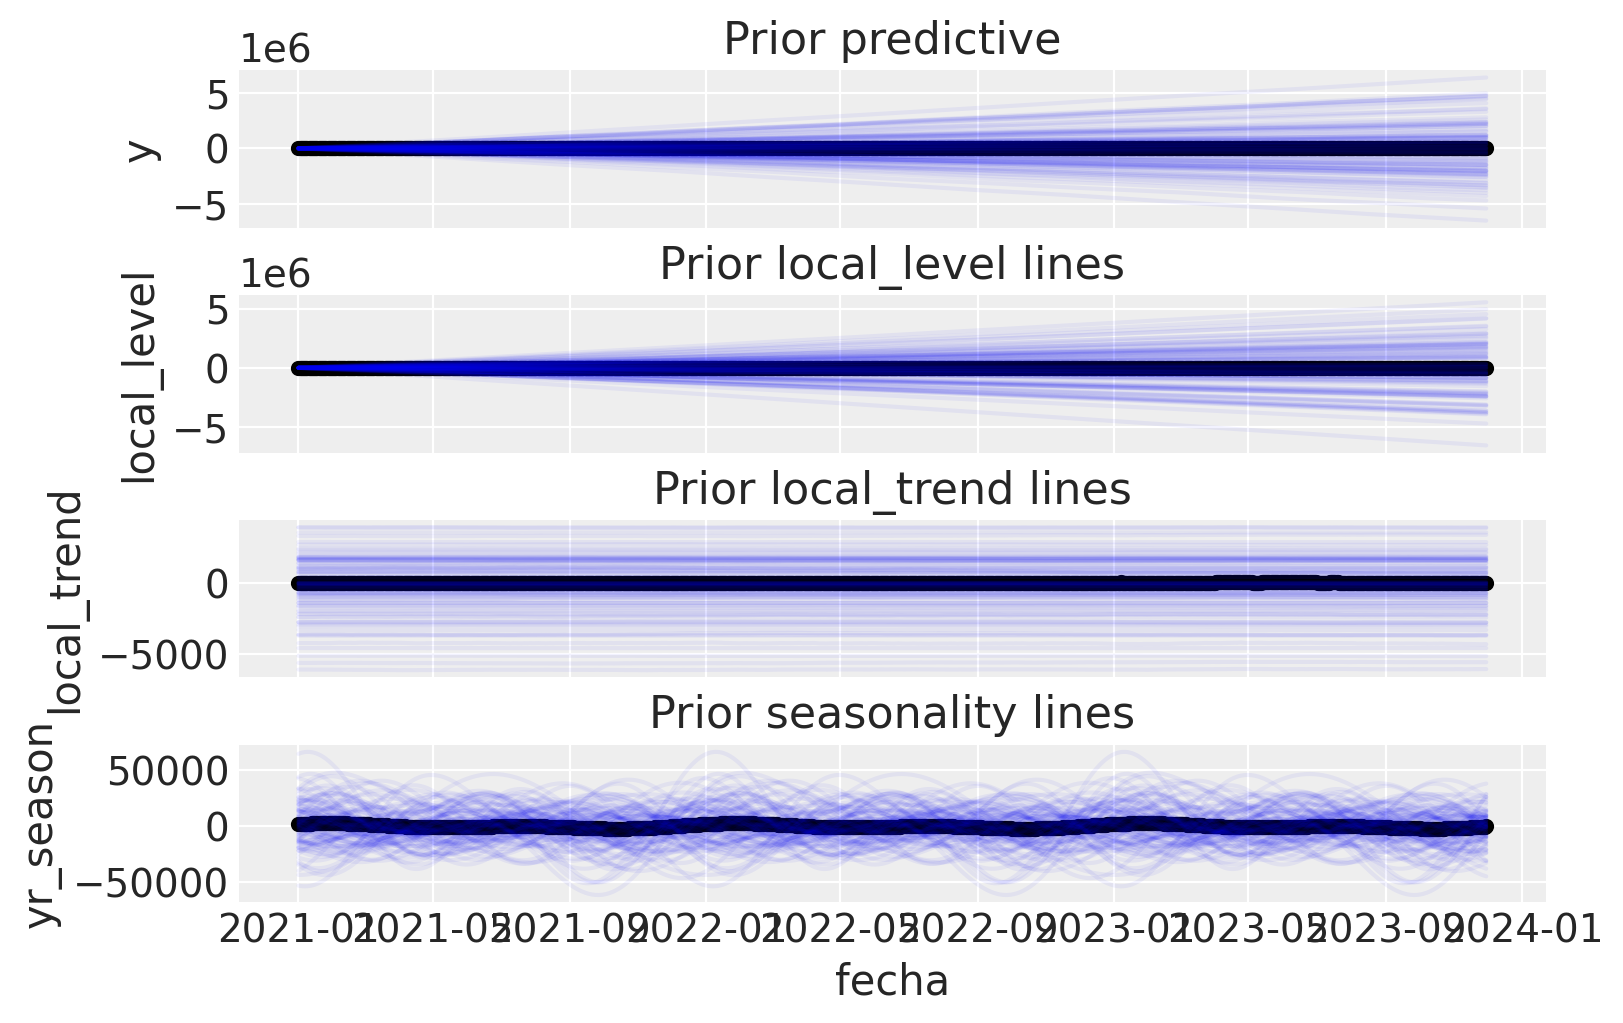

In [144]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior_predictive", num_samples=100)["y_obs"]* y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Prior local_trend lines");


ax[3].plot(
    df["fecha"],
    az.extract(trend_season_prior, group="prior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax[3])
ax[3].set_title("Prior seasonality lines");

In [145]:
with trend_season_model:
    # inference data, trace, posterior
    idata_s_t = pm.sample(
        return_inferencedata=True, 
        # target_accept=0.9,
        draws=1000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    ppc_s_t = pm.sample_posterior_predictive(trace=idata_s_t)

Compiling...
Compilation time =  0:00:03.155471
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]











Running chain 0:   0%|          | 0/2000 [00:07<?, ?it/s]





Running chain 0:  10%|█         | 200/2000 [00:11<00:31, 56.54it/s]






Running chain 0:  15%|█▌        | 300/2000 [00:23<01:42, 16.56it/s]





Running chain 0:  20%|██        | 400/2000 [00:34<02:09, 12.37it/s]





Running chain 0:  25%|██▌       | 500/2000 [00:41<01:53, 13.18it/s]




Running chain 0:  30%|███       | 600/2000 [00:52<02:04, 11.28it/s]





Running chain 0:  35%|███▌      | 700/2000 [01:04<02:09, 10.08it/s]





Running chain 0:  40%|████      | 800/2000 [01:18<02:12,  9.06it/s]





Running chain 0:  45%|████▌     | 900/2000 [01:31<02:07,  8.65it/s]





Running chain 0:  50%|█████     | 1000/2000 [01:43<01:57,  8.52it/s]


Running chain 0:  55%|█████▌    | 1100/2000 [01:52<01:38,  9.13it/s]


Running chain 0:  90%|█████████ | 1800/2000 [02:05<00:05, 34.36it/s]




Running chain 0: 100%|██████████| 2000/2000 [02:10<00:00, 40.17it/s]





Sampling time =  0:03:44.770940
Transforming variables...
Transformation time =  0:00:01.324326
Computing Log Likelihood...
Log Likelihood time =  0:00:00.871481


Sampling: [y_obs]


In [115]:
idata_s_t

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
ppc_s_t

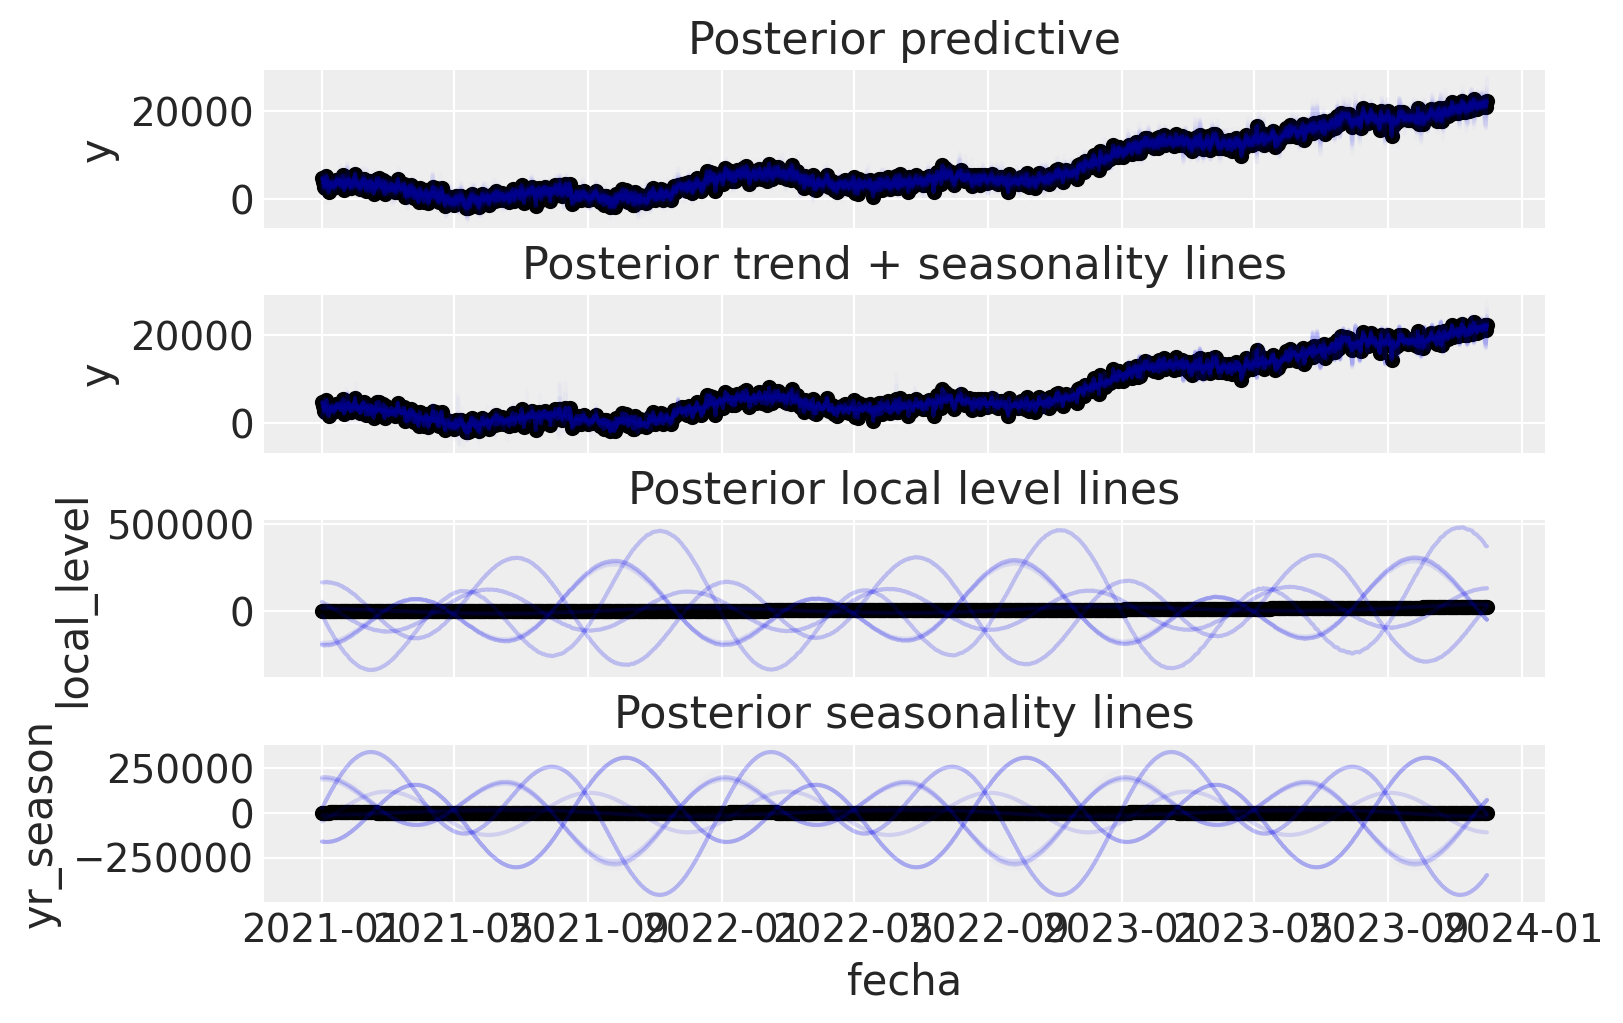

In [146]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)

ax[0].plot(
    df["fecha"],
    az.extract(ppc_s_t, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["fecha"],
    az.extract(idata_s_t, group="posterior", num_samples=100)["mu"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="y", color="k", ax=ax[1])
ax[1].set_title("Posterior trend + seasonality lines");

ax[2].plot(
    df["fecha"],
    az.extract(idata_s_t, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="local_level", color="k", ax=ax[2])
ax[2].set_title("Posterior local level lines");

ax[3].plot(
    df["fecha"],
    az.extract(idata_s_t, group="posterior", num_samples=100)["seasonality"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="fecha", y="yr_season", color="k", ax=ax[3])
ax[3].set_title("Posterior seasonality lines");

In [150]:
az.summary(idata_s_t, var_names=['~mu', "~seasonality", "~diff_local_trend", "~diff_local_level", "~local_level", "~local_trend"])*y_max

mean             sd         hdi_3%        hdi_97%  \
local_trend_0      -2665.365484    2232.528354   -5923.034409      68.342705   
local_level_0       4260.028594  112104.816635 -191792.410333  150035.017752   
beta_fourier[0]    39729.892341   85132.229174  -77865.121573  164500.890250   
beta_fourier[1]     3918.315070   44810.033392  -65221.721200   69641.216105   
beta_fourier[2]    69117.255369  110419.029919  -39365.397916  269930.902725   
beta_fourier[3]    -3394.354334  137163.808364 -229927.639565  173522.127273   
sigma_local_trend   1594.663110    1412.415897      22.780902    3758.848759   
sigma_local_level   1321.292291    1275.730488       0.000000    3303.230728   
sigma                455.618031     387.275327      22.780902    1025.140571   

                      mcse_mean       mcse_sd       ess_bulk       ess_tail  \
local_trend_0        979.578768    751.769752  136685.409431  273370.818862   
local_level_0      49912.955344  37565.706692  113904.507859  478398.933009   
beta_fourier[0]    37907.420216  28544.469670  113904.507859  478398.933009   
beta_fourier[1]    19933.288875  15012.614136  113904.507859  250589.917290   
beta_fourier[2]    49183.966494  37018.965054  113904.507859  341713.523578   
beta_fourier[3]    61075.597114  45971.859372  113904.507859  250589.917290   
sigma_local_trend    615.084342    478.398933  113904.507859  250589.917290   
sigma_local_level    569.522539    432.837130  136685.409431  410056.228293   
sigma                182.247213    136.685409  136685.409431  273370.818862   

                          r_hat  
local_trend_0      71076.412904  
local_level_0      83150.290737  
beta_fourier[0]    84289.335816  
beta_fourier[1]    98185.685775  
beta_fourier[2]    81327.818611  
beta_fourier[3]    97730.067743  
sigma_local_trend  97957.876759  
sigma_local_level  75404.784203  
sigma              62419.670307